# Introduction
The dataset contains traffic accident records in the U.S. from 2016 to 2019, which covers 49 states of the United States. There are about 3.0 million accident records in it. This project is a course work contributed by all team members.
# Team Members
Mrunmayi Anchawale, Pavan Choudhari, Maanasa Kaza and Yashvin Jagarlamudi.
# Author
Zhuocheng Lin, zhuochengg.lin@gmail.com, https://github.com/ZhuochengLin
# Project goals
1. Perform exploratory data analysis on this dataset and try to generate insights about traffic accidents in the U.S. 
2. Predict accident severity levels based on traffic accident records by using various models:
    * Logistic regression
    * Sparse logistic regression
    * Decision tree
    * Random forest

# Load data and packages

In [1]:
library(tidyverse)
library(scales)
library(lubridate)
library(plotly)
library(gridExtra)
library(tidytext)
library(modelr)
library(caret)
library(ROSE)
library(glmnet)
library(rpart)
library(rpart.plot)
library(randomForest)
options(warn = -1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.4     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


The following object is masked from ‘package:httr’:

    config




In [2]:
df <- read_csv("../input/us-accidents//US_Accidents_Dec19.csv", col_types = cols(.default = col_character())) %>% 
  type_convert()

Parsed with column specification:
cols(
  .default = col_character(),
  TMC = col_double(),
  Severity = col_double(),
  Start_Time = col_datetime(format = ""),
  End_Time = col_datetime(format = ""),
  Start_Lat = col_double(),
  Start_Lng = col_double(),
  End_Lat = col_double(),
  End_Lng = col_double(),
  `Distance(mi)` = col_double(),
  Number = col_double(),
  Weather_Timestamp = col_datetime(format = ""),
  `Temperature(F)` = col_double(),
  `Wind_Chill(F)` = col_double(),
  `Humidity(%)` = col_double(),
  `Pressure(in)` = col_double(),
  `Visibility(mi)` = col_double(),
  `Wind_Speed(mph)` = col_double(),
  `Precipitation(in)` = col_double(),
  Amenity = col_logical(),
  Bump = col_logical()
  # ... with 11 more columns
)

See spec(...) for full column specifications.



Let's take a look at the dateset:

In [3]:
df %>% head(5)

ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,⋯,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>
A-1,MapQuest,201,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.86515,-84.05872,NA,NA,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Night,Night,Night,Night
A-2,MapQuest,201,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.92806,-82.83118,NA,NA,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Night,Night,Night,Day
A-3,MapQuest,201,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.06315,-84.03261,NA,NA,⋯,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,Night,Night,Day,Day
A-4,MapQuest,201,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.74775,-84.20558,NA,NA,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Night,Day,Day,Day
A-5,MapQuest,201,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.62778,-84.18835,NA,NA,⋯,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,Day,Day,Day,Day


# Data pre-processing for visualization

In [4]:
# a function to change plot size, from https://www.kaggle.com/getting-started/105201
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

## 1. Drop variables with high NA proportion
Variables with NA proportion larger than 50% cannot give enough information to our analysis. 

These are the variables to drop:

In [5]:
df %>% summarise_all(~ mean(is.na(.))) %>% 
  pivot_longer(1:49, names_to = "Variables to drop", values_to = "NA proportion") %>% 
  filter(`NA proportion` >= 0.5)

drop_na_cols <- c("End_Lat", "End_Lng", "Number", "Wind_Chill(F)", "Precipitation(in)")

Variables to drop,NA proportion
<chr>,<dbl>
End_Lat,0.7552155
End_Lng,0.7552155
Number,0.6447172
Wind_Chill(F),0.6228696
Precipitation(in),0.6718672


## 2. Drop unuseful variables
According to our knowledge, there are some variables like "ID", "Source" and "Timezone" will not give us insights about traffic accidents or be useful in predicting severity levels, so we can drop these variables too. These variables are shown below:

In [6]:
not_useful <- c("ID", "Source", "Timezone", "Airport_Code", "Weather_Timestamp", 
                "Wind_Direction", "Description")

df %>% select(all_of(not_useful)) %>% head(5)
df_drop <- df %>% select(-all_of(drop_na_cols), -all_of(not_useful))

ID,Source,Timezone,Airport_Code,Weather_Timestamp,Wind_Direction,Description
<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>
A-1,MapQuest,US/Eastern,KFFO,2016-02-08 05:58:00,Calm,Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.
A-2,MapQuest,US/Eastern,KCMH,2016-02-08 05:51:00,Calm,Accident on Brice Rd at Tussing Rd. Expect delays.
A-3,MapQuest,US/Eastern,KI69,2016-02-08 06:56:00,SW,Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.
A-4,MapQuest,US/Eastern,KDAY,2016-02-08 07:38:00,SW,Accident on I-75 Southbound at Exits 52 52B US-35. Expect delays.
A-5,MapQuest,US/Eastern,KMGY,2016-02-08 07:53:00,SW,Accident on McEwen Rd at OH-725 Miamisburg Centerville Rd. Expect delays.


Here, at first we thought "Wind_Direction" should be one useful factor to our project. But when we plot its distribution under each severity level, the result shows it doesn't have a great impact on severity because the distribution is similar in each severity level. 

Plus, it has 25 levels, which will add more complexity to model building part. So we decide to drop it.

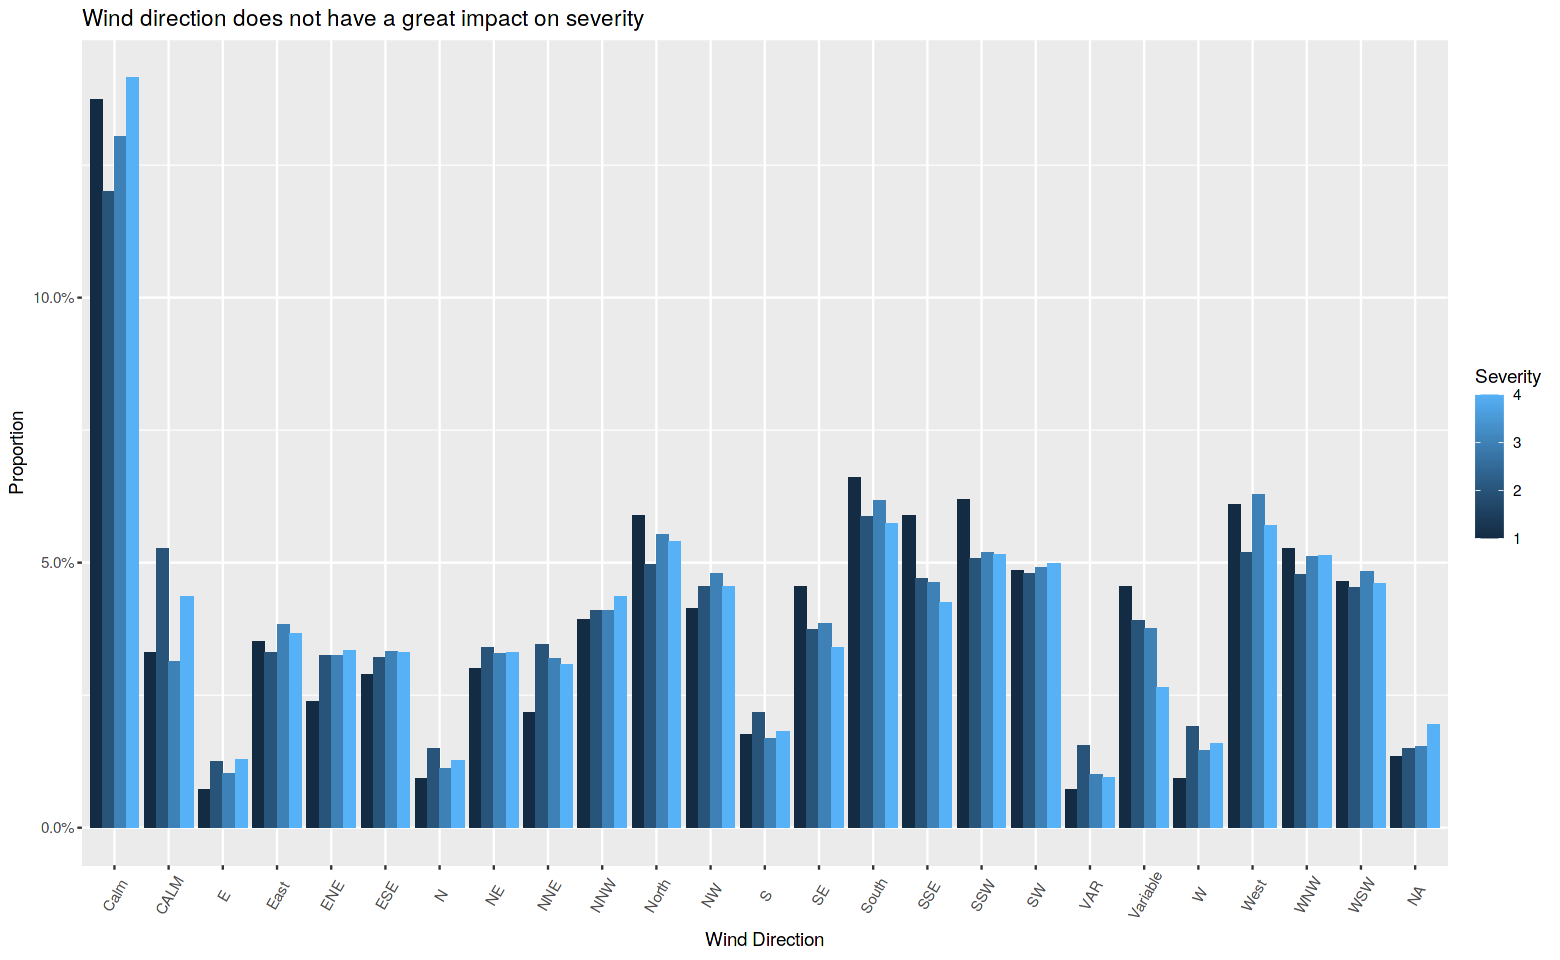

In [7]:
fig(13, 8)
ggplot(df, aes(Wind_Direction, ..prop.., group = Severity)) +
  geom_bar(aes(fill = Severity), position = "dodge") +
  scale_y_continuous(labels = percent) +
  labs(x = "Wind Direction",
       y = "Proportion",
       title = "Wind direction does not have a great impact on severity") +
  theme(axis.text.x = element_text(angle = 60, vjust = 0.6))

## 3. Rename variables to avoid potential error
A variable name containing "(" or ")" is a dangerous thing, because some functions may not be able to treat the name correctly.

In [8]:
df_drop <-  df_drop %>%
  rename("Distance" = `Distance(mi)`, "Temperature" = `Temperature(F)`, "Humidity" = `Humidity(%)`, 
         "Pressure" = `Pressure(in)`, "Visibility" = `Visibility(mi)`, "Wind_Speed" = `Wind_Speed(mph)`)

## 4. Transform time related variables
As we can see, in the original dataset, time variables are in a format that is difficult to manipulate. Also, we will lose a lot of information if we consider date and time as a whole, because some patterns may be hidden behind this format, like hourly, weekly or monthly pattern. So we need to transform the time related variables to several new variables:

* The original:

In [9]:
df_drop %>% select(Start_Time, End_Time) %>% head(5)

Start_Time,End_Time
<dttm>,<dttm>
2016-02-08 05:46:00,2016-02-08 11:00:00
2016-02-08 06:07:59,2016-02-08 06:37:59
2016-02-08 06:49:27,2016-02-08 07:19:27
2016-02-08 07:23:34,2016-02-08 07:53:34
2016-02-08 07:39:07,2016-02-08 08:09:07


In [10]:
df_time <- df_drop %>%
  mutate(Duration = as.numeric(End_Time - Start_Time)) %>%
  # accident duration should be positive
  filter(!(Duration < 0)) %>%
  separate(Start_Time, into = c("Date", "Time"), sep = " ") %>%
  mutate("Year" = str_sub(Date, 1, 4), "Month" = str_sub(Date, 6, 7), "Day" = str_sub(Date, 9, 10), 
         "Wday" = as.character(wday(Date)), "Hour" = str_sub(Time, 1, 2)) %>%
  select(-c("Date", "Time", "End_Time")) %>%
  select(TMC, Severity, Year, Month, Day, Hour, Wday, Duration, everything())

* After transformation:

In [11]:
df_time %>%
  select(Year, Month, Day, Hour, Wday, Duration) %>%
  head(5)

Year,Month,Day,Hour,Wday,Duration
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2016,02,08,05,2,18840
2016,02,08,06,2,1800
2016,02,08,06,2,1800
2016,02,08,07,2,1800
2016,02,08,07,2,1800


## 5. Drop weather condition NA level

The "Weather_Condition" variable has a NA level, which means the weather condition information is missing. 

To deal with NA values in a categorical variable, usually there are 2 methods we can use:

1. Treat NA as a new level, which will not lose other features' information.
2. Remove all records containing this variable's NA value.

Before we decide, there is one interesting thing: when weather condition is missing, there is a good chance that other weather related variables will be missing too. 

In [12]:
df_time %>% filter(is.na(Weather_Condition)) %>% select(Temperature:Weather_Condition) %>%
  head(10) 

Temperature,Humidity,Pressure,Visibility,Wind_Speed,Weather_Condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
48.2,93,29.51,10,9.2,NA
NA,NA,NA,NA,NA,NA
95.0,20,29.87,10,6.9,NA
91.4,28,29.94,10,15.0,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA


So it should be safe to remove all records containing NA weather condition level.

In [13]:
df_weather <- df_time %>% filter(!is.na(Weather_Condition))

## 6. Handle TMC NA values
TMC code indicates the type of an accident, which makes it an important feature of accident records. However, when we plot the TMC distribution under each severity level, there is a large number of NA values in severity level 4.

Here, since NA value seems like an important feature of severity level 4, we decide to treat NA value as a new level of TMC. 

In [14]:
df_TMC <- df_weather %>%
  mutate(TMC = replace_na(TMC, "NA_TMC"))

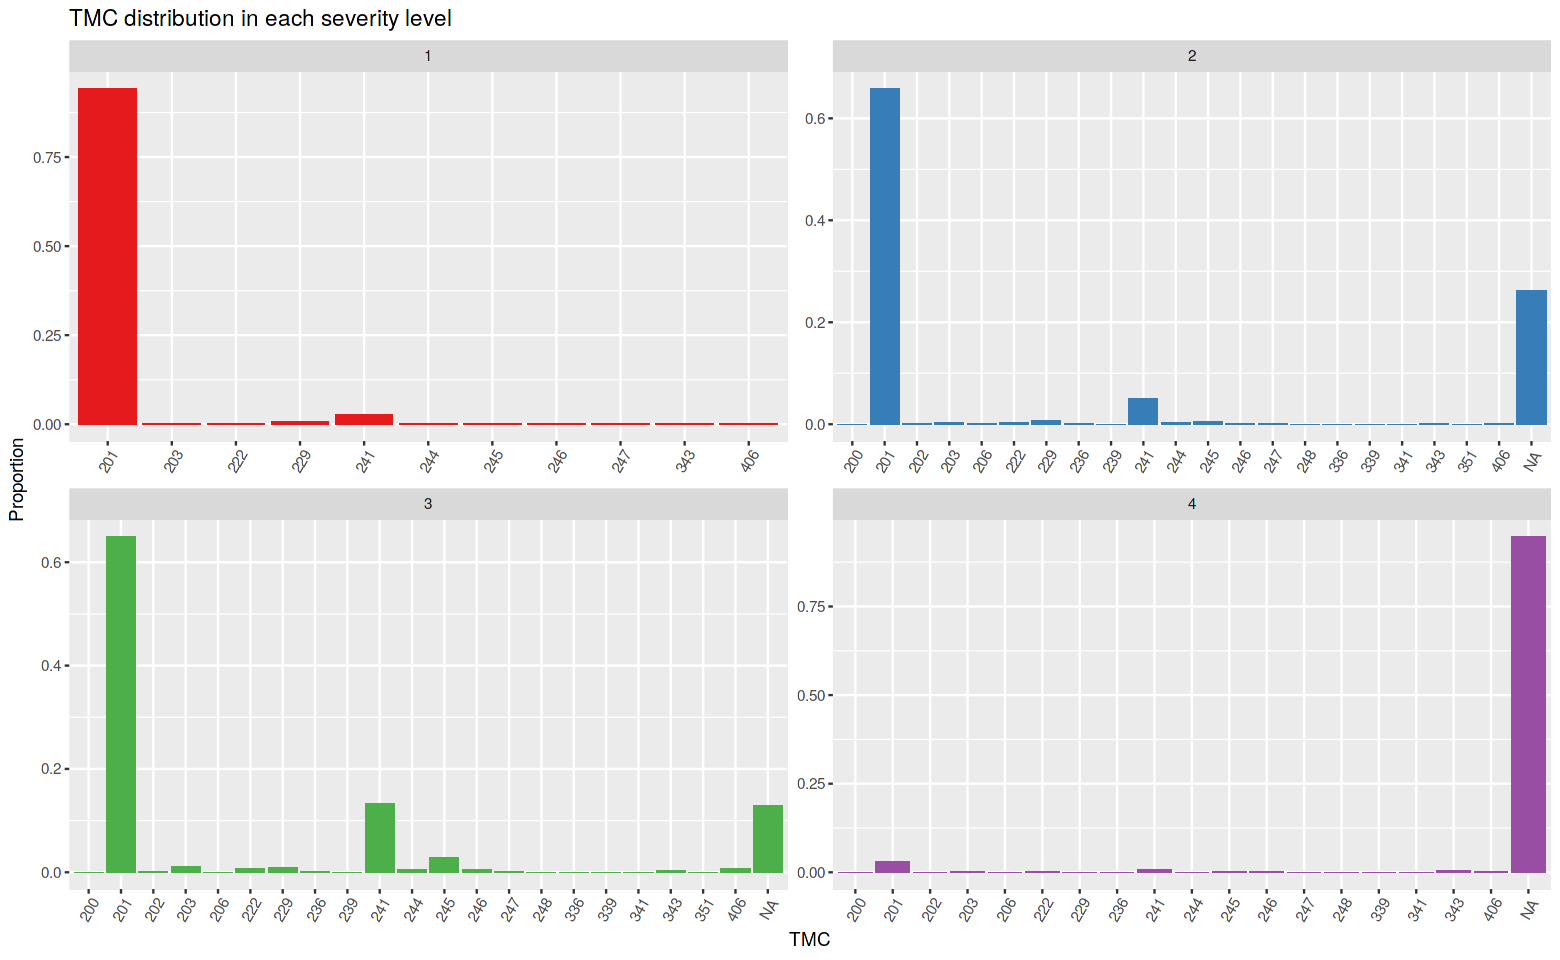

In [15]:
fig(13, 8)
df_weather %>% 
  ggplot(aes(factor(TMC), ..prop..)) +
    geom_bar(aes(group = Severity, fill = factor(Severity)), show.legend = F) +
    facet_wrap(~ Severity, scales = "free") +
    labs(x = "TMC",
         y = "Proportion",
         title = "TMC distribution in each severity level") +
    theme(axis.text.x = element_text(angle = 60, vjust = 0.6),
          legend.position = "top") +
  scale_fill_brewer(palette = "Set1")

## 7. Location related variables

There are several variables indicating the location of the accident. Apart from the accurate coordinate, longitude and latitude, the dataset also contains state, city, county and even street address. However, they are not all useful in this project. 

When we are doing exploratory data analysis, we want to find some nationwide patterns or statewide patterns from this dataset. And further analysis on city, county or street level may be done later. So, let's drop these variabls for now.

In [16]:
address <- c("Country", "City", "County", "Street", "Zipcode")
df_TMC %>%
  select(all_of(address)) %>%
  head(5)

Country,City,County,Street,Zipcode
<chr>,<chr>,<chr>,<chr>,<chr>
US,Dayton,Montgomery,I-70 E,45424
US,Reynoldsburg,Franklin,Brice Rd,43068-3402
US,Williamsburg,Clermont,State Route 32,45176
US,Dayton,Montgomery,I-75 S,45417
US,Dayton,Montgomery,Miamisburg Centerville Rd,45459


In [17]:
df_add <- df_TMC %>% select(-all_of(address))

## 8. Modify variable type
When reading the data into R, some variables will not be recognized as the right type as we expected. For example, it's more reasonable to treat TMC, severity and time related variables as categorical variables than continuous variables. Also, logistic variables and be treated as categorical.

In [18]:
df_add <- df_add %>% 
  mutate(TMC = as.character(TMC), Severity = as.character(Severity)) %>% 
  mutate_if(is.logical, as.character)

## 9. Handle NA values in continuous variables
There are still some records containing NA values in continuous variables, which is not a big issue. We can replace these NA values with the mean of the corresponding variable. After replacement, we can see the summary of all continuous variables, there are no NA values now.

In [19]:
df_mean <- df_add %>%
  mutate_if(is.numeric, ~ replace_na(., mean(., na.rm = T)))

summary(df_mean %>% select_if(is.numeric))

    Duration          Start_Lat       Start_Lng          Distance       
 Min.   :      73   Min.   :24.56   Min.   :-124.62   Min.   :  0.0000  
 1st Qu.:    1783   1st Qu.:33.54   1st Qu.:-117.30   1st Qu.:  0.0000  
 Median :    2675   Median :35.82   Median : -90.25   Median :  0.0000  
 Mean   :    7063   Mean   :36.48   Mean   : -95.47   Mean   :  0.2831  
 3rd Qu.:    4481   3rd Qu.:40.41   3rd Qu.: -80.95   3rd Qu.:  0.0100  
 Max.   :91680802   Max.   :49.00   Max.   : -67.11   Max.   :333.6300  
  Temperature        Humidity         Pressure       Visibility     
 Min.   :-40.00   Min.   :  1.00   Min.   : 0.00   Min.   :  0.000  
 1st Qu.: 50.00   1st Qu.: 49.00   1st Qu.:29.82   1st Qu.: 10.000  
 Median : 64.40   Median : 67.00   Median :29.98   Median : 10.000  
 Mean   : 62.38   Mean   : 65.41   Mean   :29.83   Mean   :  9.151  
 3rd Qu.: 76.00   3rd Qu.: 84.00   3rd Qu.:30.11   3rd Qu.: 10.000  
 Max.   :170.60   Max.   :100.00   Max.   :33.04   Max.   :140.000  
   Win

## 10. Handle NA values in categorical variables

NA values in continuous variables are handled properly, but there may be NA values in categorical variables too.

We can see only a few records need to be handled (81 records in total, the NA values in the last 4 variables come from the same 80 records), so removing them is a safe method.

In [20]:
df_mean %>% summarise_all(~sum(is.na(.))) %>% 
  pivot_longer(everything(), names_to = "Variable", values_to = "NA_count") %>% filter(NA_count > 0)

Variable,NA_count
<chr>,<int>
Side,1
Sunrise_Sunset,80
Civil_Twilight,80
Nautical_Twilight,80
Astronomical_Twilight,80


In [21]:
df_final <- df_mean %>%
  filter(!is.na(Side)) %>%
  filter(!is.na(Sunrise_Sunset))

## 11. Write into a csv file for future use

In [22]:
 write_csv(df_final, "tidy.csv")

# Visualization
In this section, we're going to explore this dataset and try to generate some insights through various visualization methods. Since the size of this dataset is quite large and it has 36 columns now, we can come up with as many plots as we want. But appearantly not all plots are interesting or useful. So we will only show several plots that make us interested or feel strange.

Remember to set correct type to each variable:

In [23]:
df <- read_csv("./tidy.csv", col_types = cols(.default = col_character())) %>% 
    type_convert() %>%
    mutate(TMC = factor(TMC), Severity = factor(Severity), Year = factor(Year), Wday = factor(Wday)) %>%
    mutate_if(is.logical, factor) %>%
    mutate_if(is.character, factor)

Parsed with column specification:
cols(
  .default = col_logical(),
  TMC = col_character(),
  Severity = col_double(),
  Year = col_double(),
  Month = col_character(),
  Day = col_character(),
  Hour = col_character(),
  Wday = col_double(),
  Duration = col_double(),
  Start_Lat = col_double(),
  Start_Lng = col_double(),
  Distance = col_double(),
  Side = col_character(),
  State = col_character(),
  Temperature = col_double(),
  Humidity = col_double(),
  Pressure = col_double(),
  Visibility = col_double(),
  Wind_Speed = col_double(),
  Weather_Condition = col_character(),
  Sunrise_Sunset = col_character()
  # ... with 3 more columns
)

See spec(...) for full column specifications.



## 1. Accident count
This dataset contains traffic accident records in 49 states. We can use a map to see the accident distribution from 2016 to 2019. 
The top 10 states with the most accident count are highlighted in the map. Later in the modeling part we will mainly focus on these 10 states.

In [24]:
states <- map_data("state") %>% as_tibble() %>% select(long, lat, group, region)
states_abb <- read_csv("../input//usa-state-name-code-and-abbreviation//data.csv") %>%
  mutate(State = tolower(State)) %>%
  select(State, Code) %>%
  rename("State_full" = State)
accident_count <- df %>%
  count(State) %>%
  left_join(states_abb, by = c("State" = "Code"))

Parsed with column specification:
cols(
  State = col_character(),
  Abbrev = col_character(),
  Code = col_character()
)



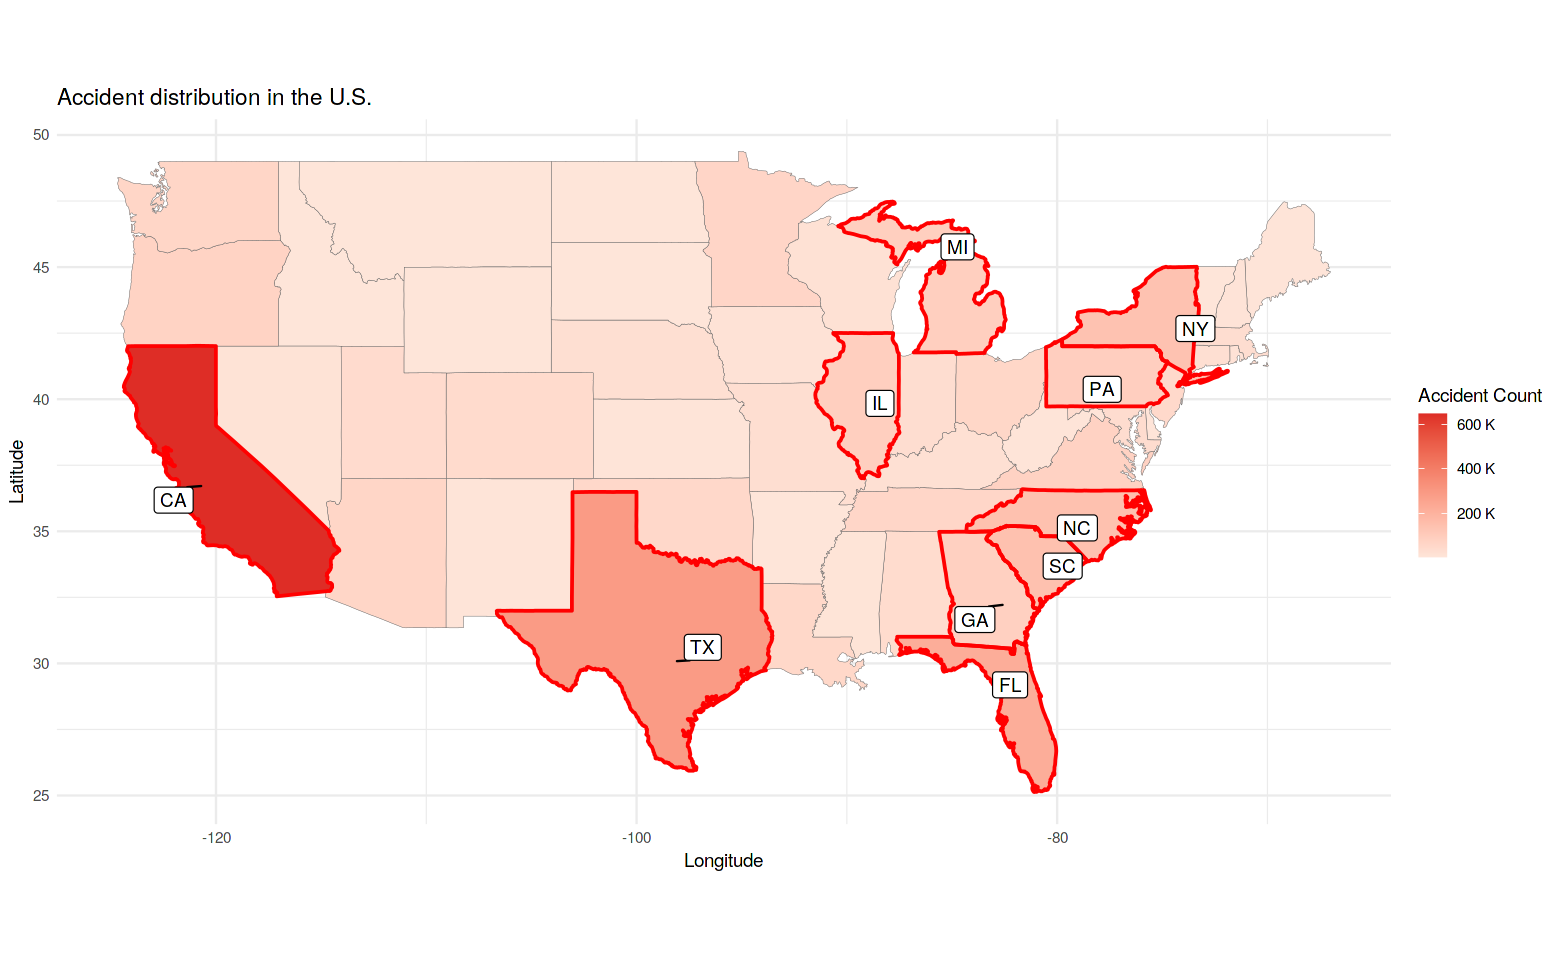

In [25]:
states <- states %>%
  left_join(accident_count, by = c("region" = "State_full"))
# top 10 states
top_10 <- accident_count %>%
  arrange(desc(n)) %>%
  head(10)
top_10 <- top_10$State %>% unlist()

top_10_map <- states %>%
  filter(State %in% top_10)
top_10_label <- top_10_map %>%
  group_by(region, State) %>%
  summarise(long = mean(long), lat = mean(lat))

ggplot(states, aes(long, lat, group = group)) +
  geom_polygon(aes(fill = n), color = "#636363", size = 0.1) +
  geom_polygon(data = top_10_map, color = "red", fill = NA, size = 0.8) +
  scale_fill_gradient(low = "#fee5d9", high = "#de2d26",
                      name = "Accident Count", labels = unit_format(unit = "K", scale = 1e-03)) +
  ggrepel::geom_label_repel(mapping = aes(label = State, group = 1), data = top_10_label) +
  theme_minimal() +
  coord_quickmap() +
  labs(title = "Accident distribution in the U.S.",
       x = "Longitude",
       y = "Latitude")

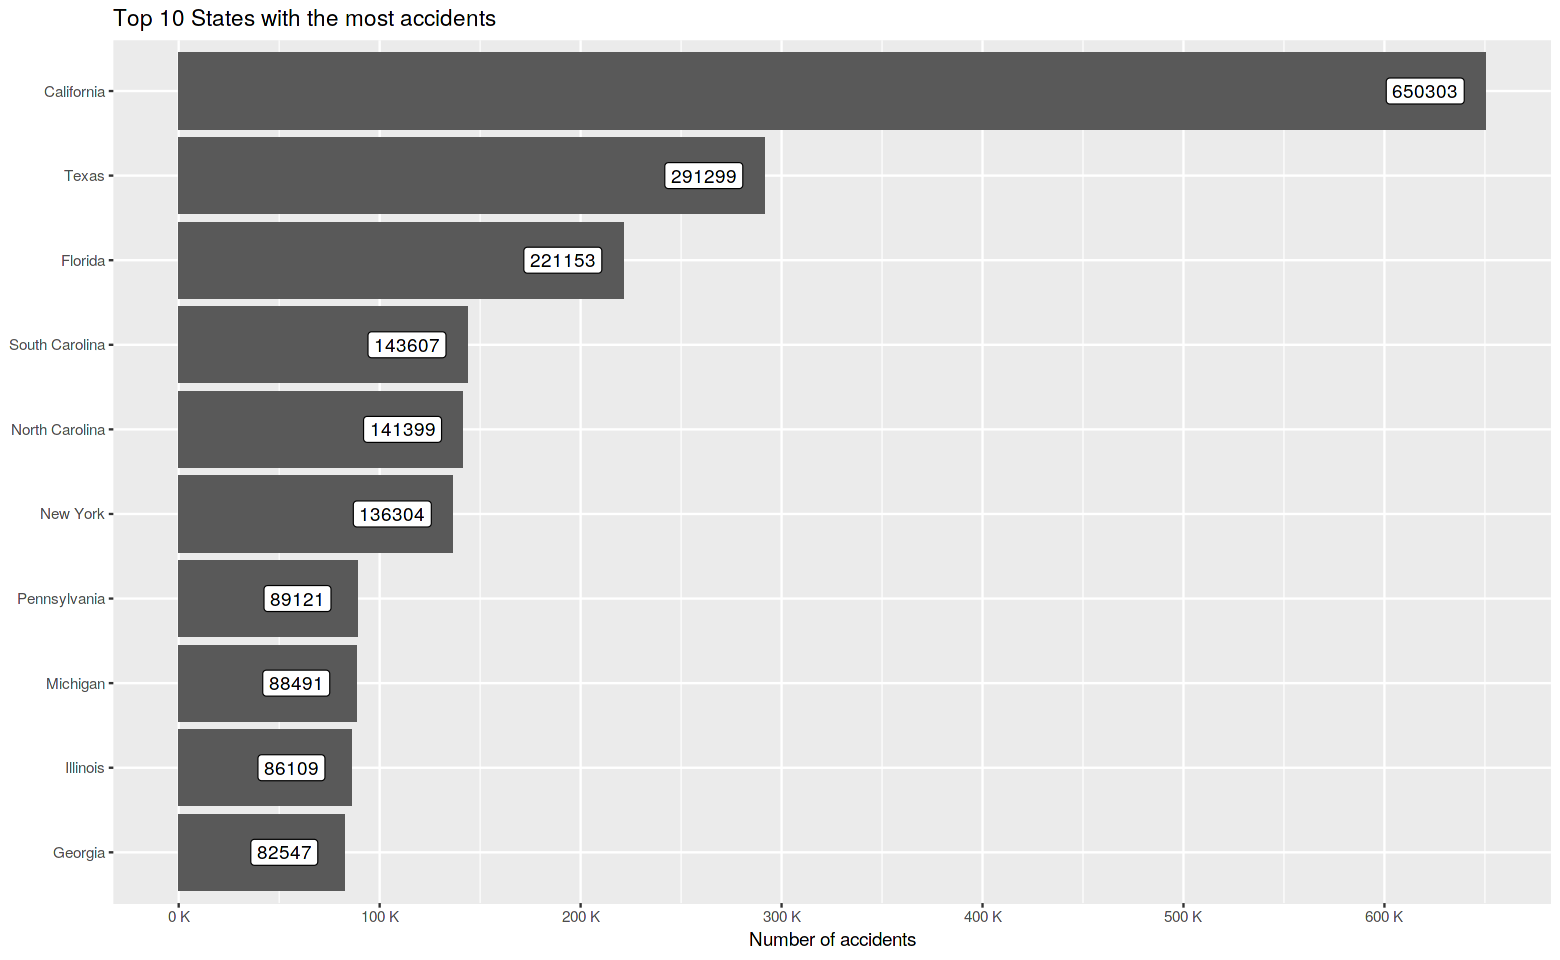

In [26]:
df %>% 
  filter(State %in% top_10) %>%
  count(State) %>%
  ggplot(aes(reorder(State, n), n)) +
  geom_col() +
  geom_label(aes(label = n), nudge_y = -30000) +
  labs(x = NULL, y = "Number of accidents",
       title = "Top 10 States with the most accidents") +
  scale_x_discrete(labels = rev(c("California", "Texas", "Florida", "South Carolina",
                              "North Carolina", "New York", "Pennsylvania",
                              "Michigan", "Illinois", "Georgia"))) +
  scale_y_continuous(breaks = seq(0, 700000, 100000), labels = unit_format(unit = "K", scale = 1e-03)) +
  coord_flip()

## 2. Distance affected by accidents
The "Distance" variable in the dataset means the length of the road extent affected by the accident. We would like to know the relationship between distance and severity levels.

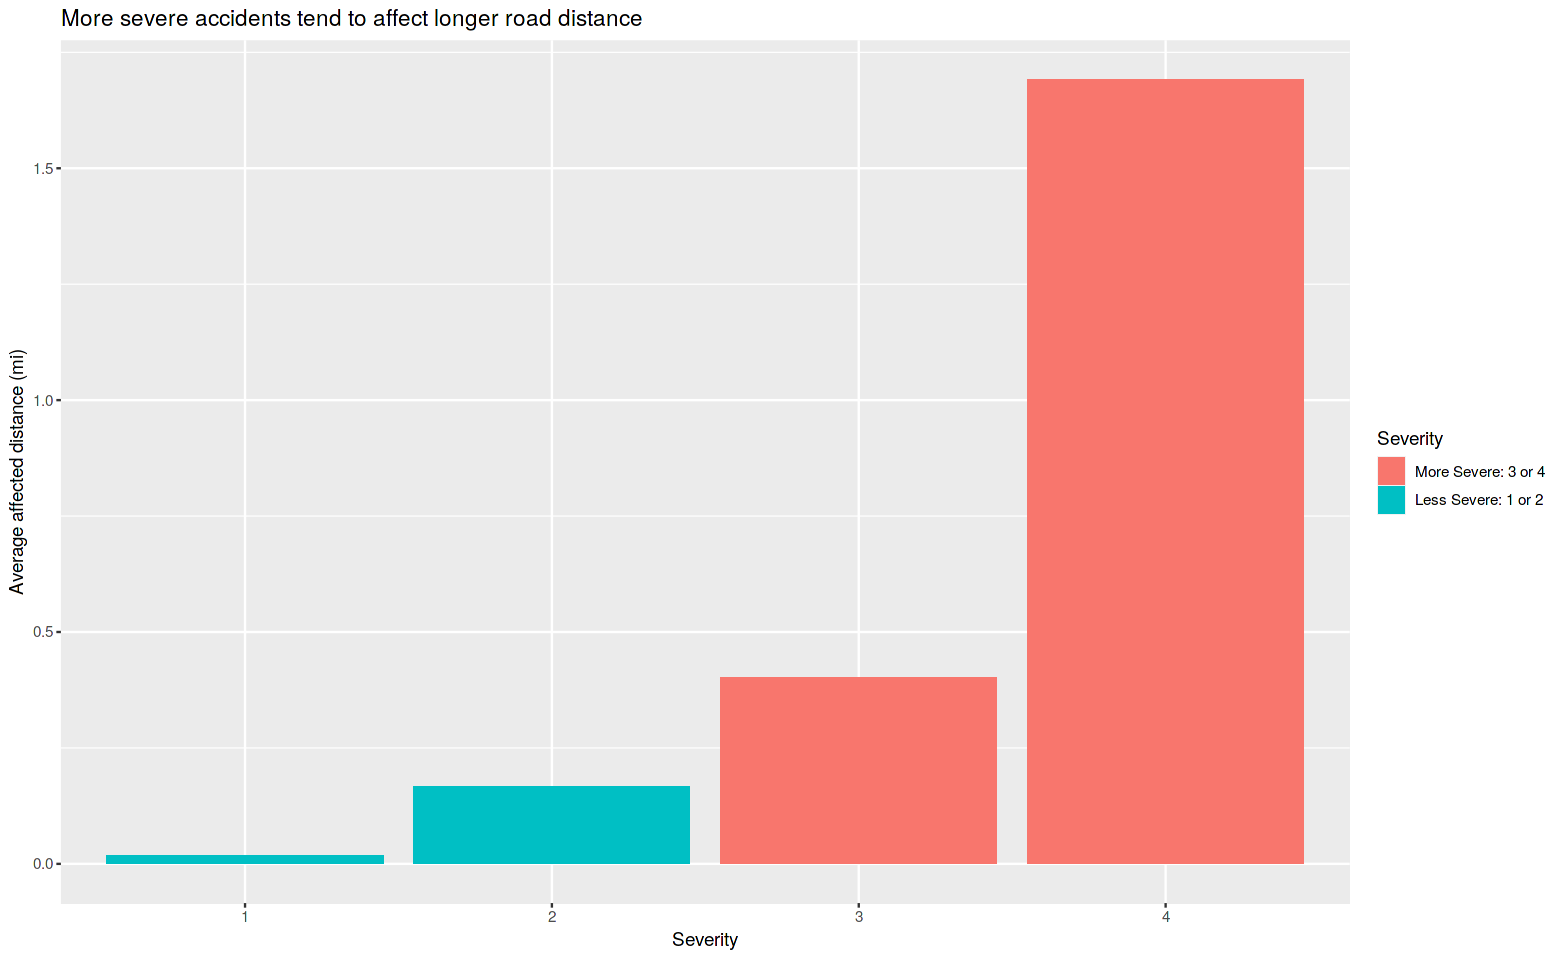

In [27]:
fig(13, 8)
df %>%
  group_by(Severity) %>%
  summarise(prop = mean(Distance)) %>%
  ggplot(aes(Severity, prop, fill = !Severity %in% c(3, 4))) +
    geom_col() +
    labs(
      y = "Average affected distance (mi)",
      title = "More severe accidents tend to affect longer road distance") +
    scale_fill_discrete(name = "Severity", labels = c("More Severe: 3 or 4", "Less Severe: 1 or 2"))

## 3. Accident count in each severity level
According to our understanding, the severity level distribution in each year should be similar assuming the traffic condition does not change remarkably from 2016 to 2019. 

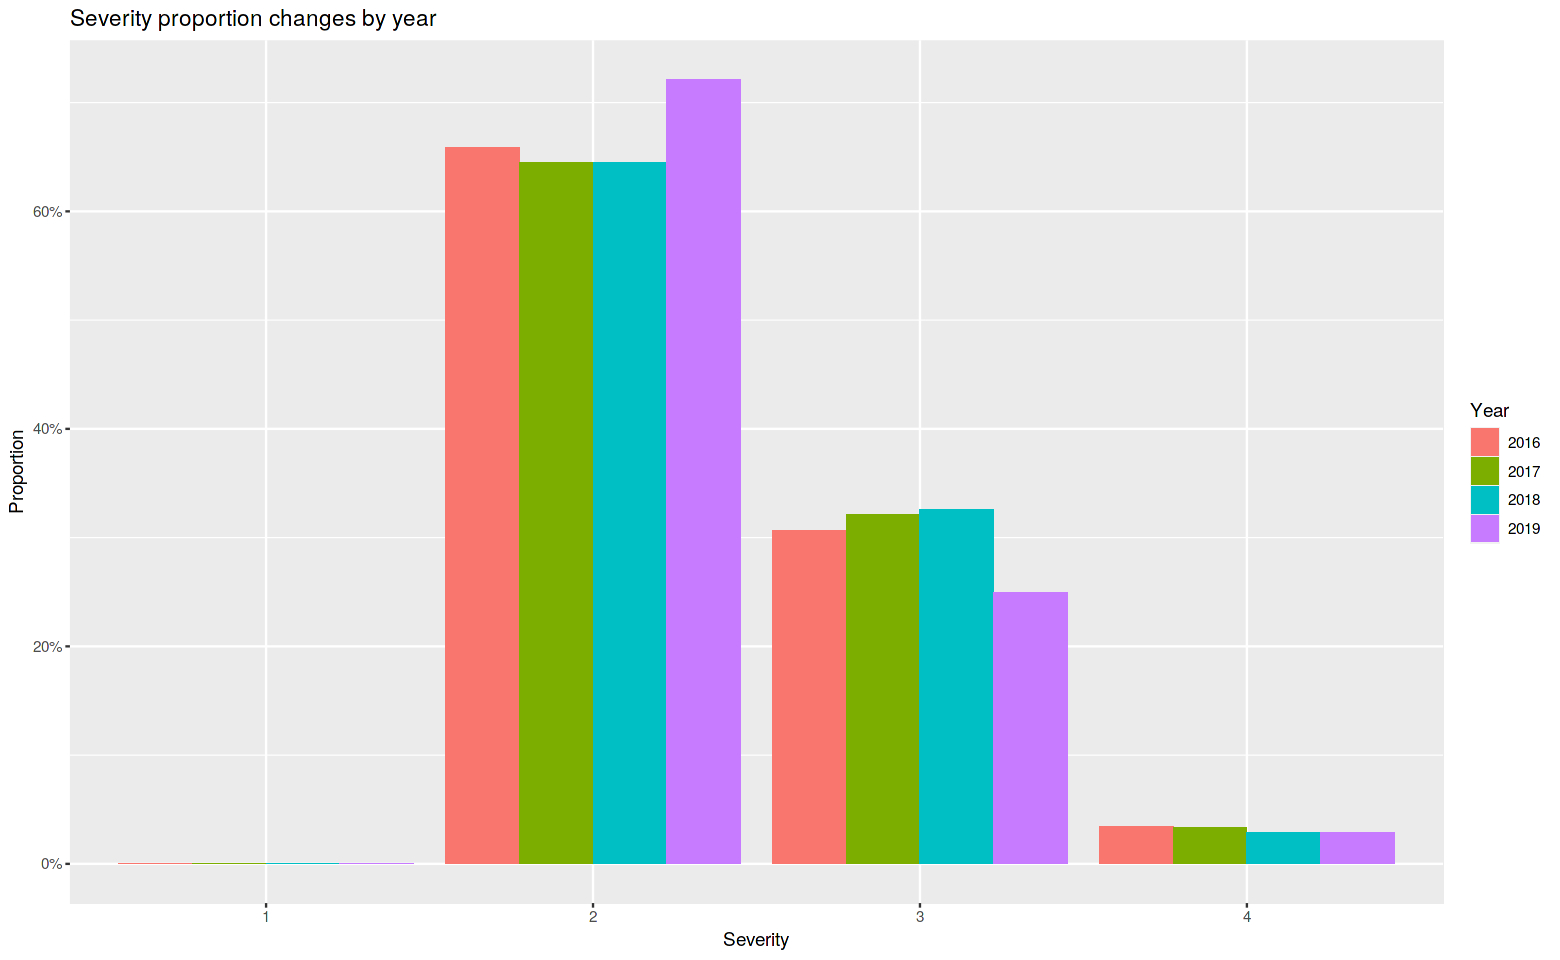

In [28]:
fig(13, 8)
df %>%
  group_by(Year, Severity) %>%
  count() %>%
  group_by(Year) %>%
  mutate(sum = sum(n)) %>%
  mutate(Proportion = n / sum) %>%
  ggplot(aes(Severity, Proportion)) +
  geom_col(aes(fill = Year), position = "dodge") +
  labs(x = "Severity",
       y = "Proportion",
       title = "Severity proportion changes by year") +
  scale_y_continuous(labels = percent)

The result shows from 2018 to 2019, severity level 2 has a sudden increase while level 3 has a sudden decrease, whicn seems a little strange. 

Right now we still cannot give a valid explanation to this result. To answer this, we may need to do some further research, like talking to someone from the traffic data source. Because what if the rule itself to distinguish level 2 and level 3 has changed since 2018, there is no way we can confirm this by ourselves. 

One more thing to bear in mind, this dataset is seriously unbalanced in different severity levels: most of the accidents are classified into level 2 and level 3.

## 4. Accident account in different time scales
One interesting thing we find is that when we split the original time variable into several new variables, some patterns can be revealed by visualization.

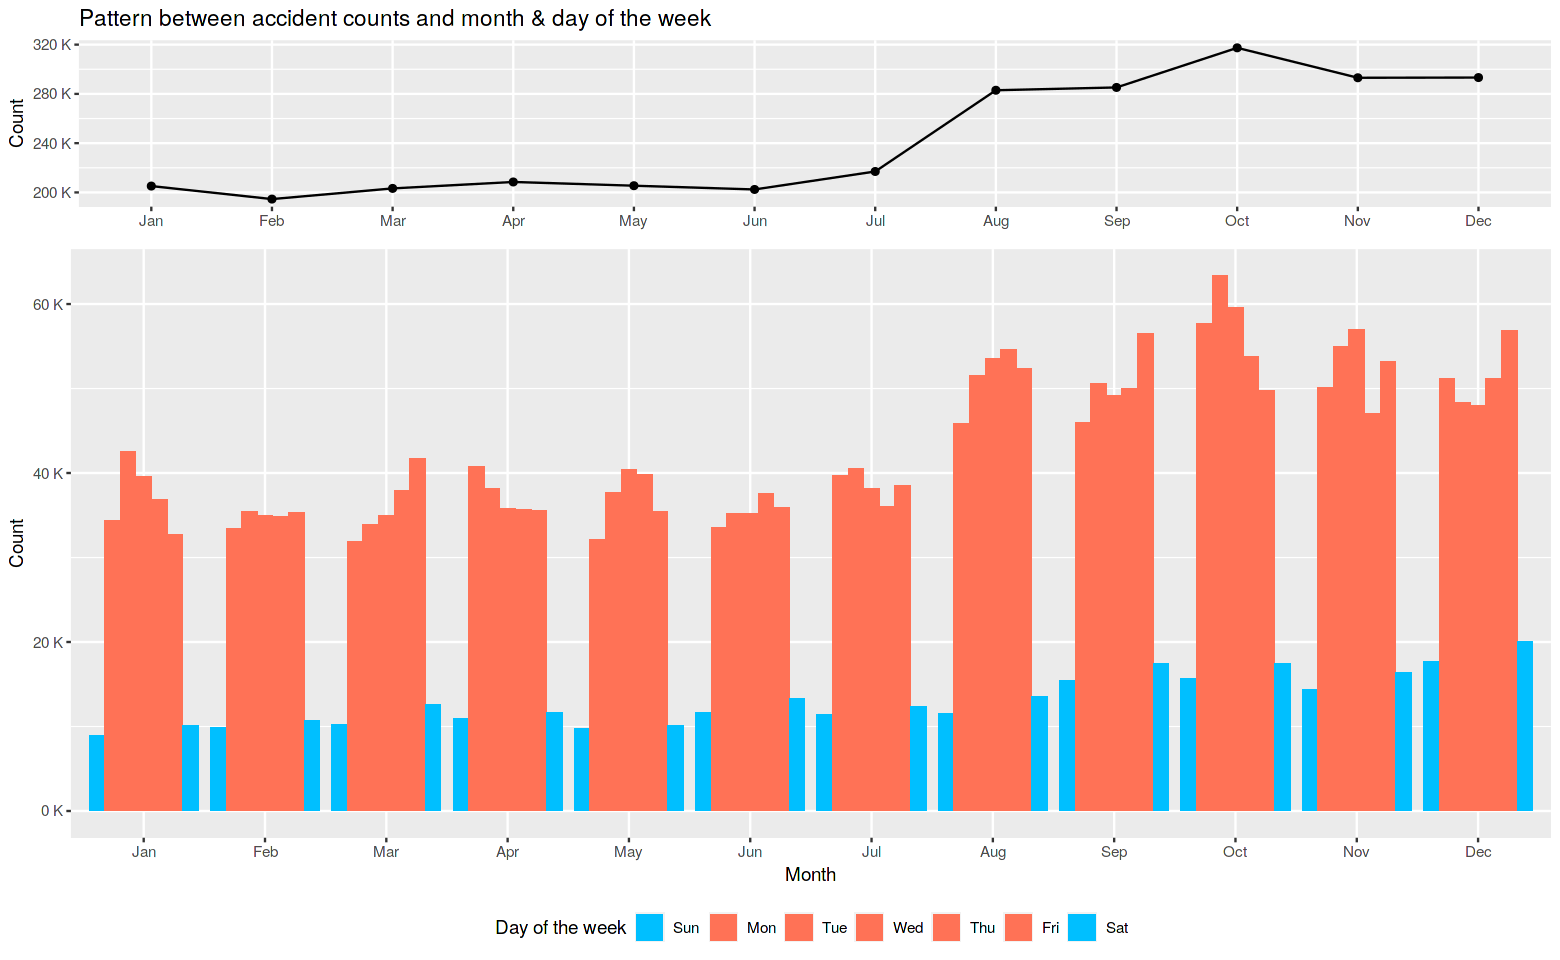

In [29]:
g_top <- df %>%
  count(Month) %>%
  ggplot(aes(Month, n)) +
  geom_line(aes(group = 1)) +
  geom_point() +
  labs(y = "Count",
       x = NULL,
    title = "Pattern between accident counts and month & day of the week") +
  scale_x_discrete(labels = c("Jan", "Feb", "Mar", "Apr", "May",
                              "Jun", "Jul", "Aug", "Sep", "Oct",
                              "Nov", "Dec")) +
  scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-03))

g_bottom <- df %>%
  ggplot(aes(Month, fill = Wday)) +
  geom_bar(position = "dodge") +
  scale_fill_manual(values = c("deepskyblue1", "coral1", "coral1","coral1","coral1","coral1", "deepskyblue1"),
                    name = "Day of the week",
                    labels = c("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")) +
  theme(legend.position = "bottom") +
  guides(fill = guide_legend(nrow = 1)) +
  scale_x_discrete(labels = c("Jan", "Feb", "Mar", "Apr", "May",
                              "Jun", "Jul", "Aug", "Sep", "Oct",
                              "Nov", "Dec")) +
  labs(y = "Count") +
  scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-03))

grid.arrange(g_top, g_bottom, heights = c(1/4, 3/4))

From this plot, the first thing we can see is that the accident count experiences an obvious increase after July and a sudden decrease in January. And from the bottom subplot, we can recognize the weekly pattern of accidents: more accidents happen during weekdays and fewer accidents happen during weekends. Also, when we look closely, after July, it seems the month has more impact on weekdays' accidents than weekends' because apparently from August to December the weekdays' accidents experience a higher increase than weekends'.

The weekly pattern is easy to explain, since people are more busy during weekdays, there should be more vehicles on the road. As for the monthly pattern, we suppose this may be the result of holiday season and many schools' reopening. To answer this with certainty, further research is needed.

Also, the hourly pattern of accidents is worth mentioning too.

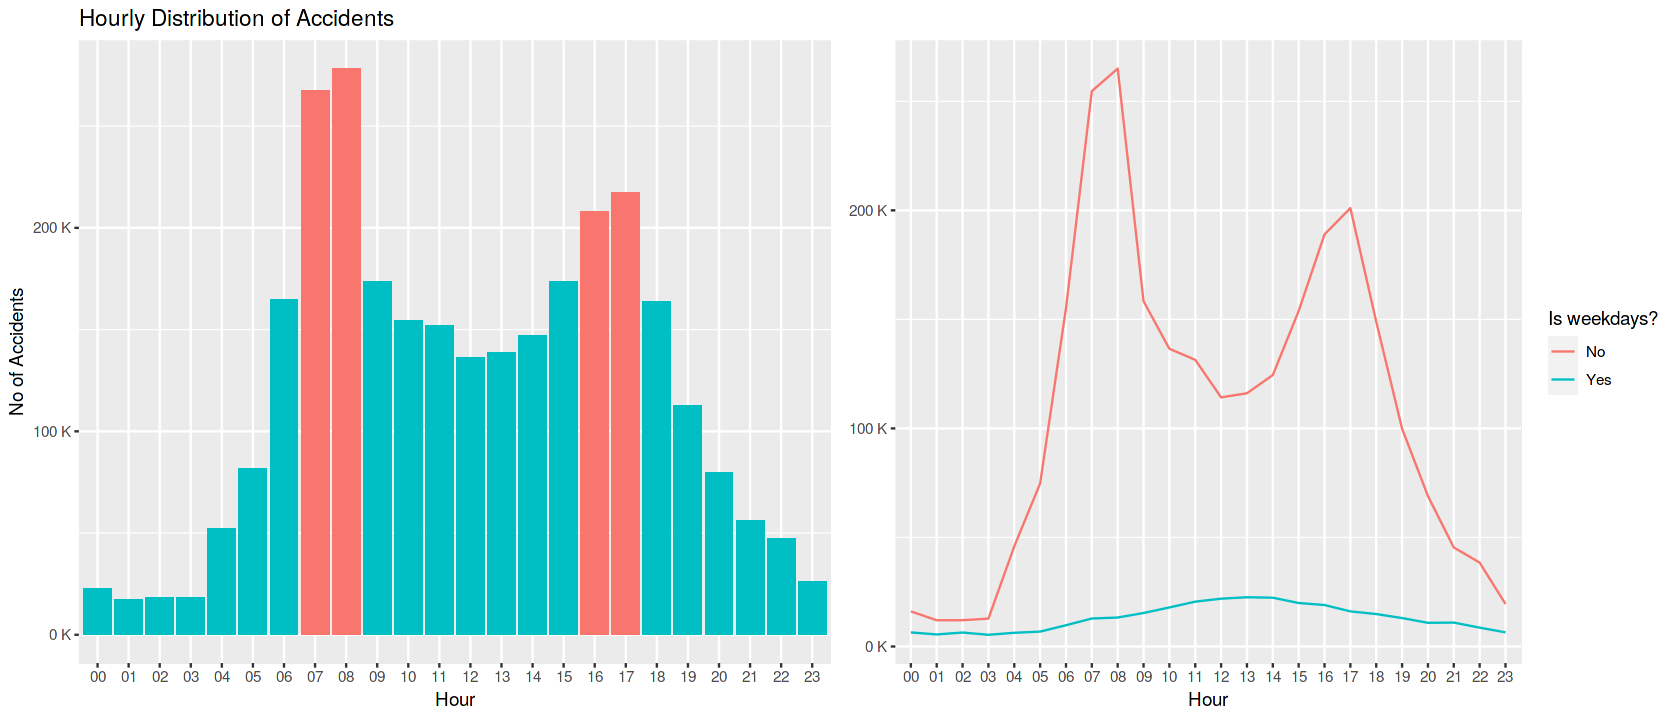

In [30]:
fig(14, 6)
right <- df %>%
  ggplot(aes(Hour, color = Wday %in% c("1", "7"), group = Wday %in% c("1", "7"))) +
  geom_freqpoly(stat = "count") +
  scale_color_discrete(name = "Is weekdays?", labels = c("No", "Yes")) +
  labs(y = NULL,
       title = " ") +
  scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-03))

left <- df %>%
  ggplot(aes(Hour, fill = !Hour %in% c("07", "08", "16", "17"))) +
    geom_bar(show.legend = F) +
    labs(x = "Hour",
         y = "No of Accidents",
         title = "Hourly Distribution of Accidents") +
  scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-03))

grid.arrange(left, right, widths = c(1/2, 1/2))

Is seems most accidents happen at these two intervals: 7am - 8am, 16pm - 17pm. And then when we look at the hourly patterns separately on weekdays and weekends, we notice that the previous result should be attributed to the hourly pattern on weekdays because 7am - 8am and 16pm - 17pm are the time when most people commute on weekdays. As for the hourly pattern on weekends, we can only conclude that most accidents happen during daytime.

## 5. The impact of weather condition on accident severity
Common sense suggests that weather condition should have a great impact on accident severity. It's reasonable to think severe accidents happen more often during bad weathers, and less severe ones happen more often during clear days. However, the result of visualization seems to be against this opinion.

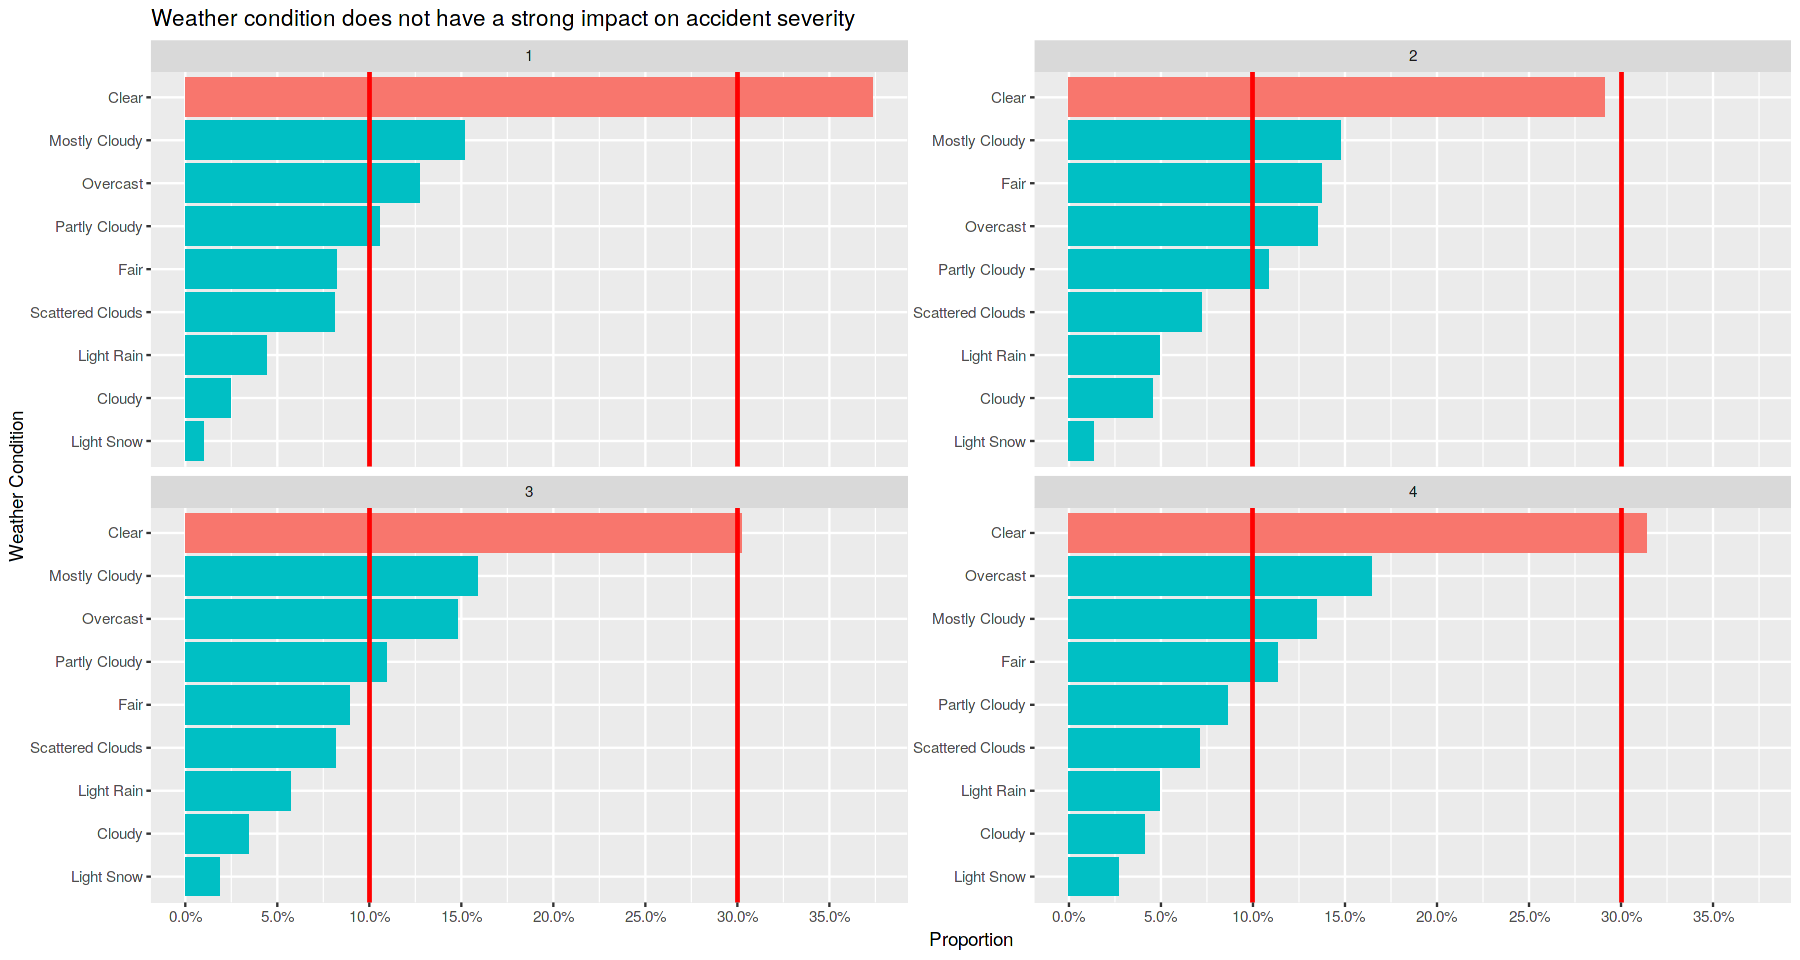

In [31]:
fig(15, 8)
weather <- df %>% group_by(Severity) %>% count(Weather_Condition) %>% mutate(n = n / sum(n)) %>% filter(n > 0.02)
weather <- weather$Weather_Condition

df %>%
  filter(Weather_Condition %in% weather) %>%
  group_by(Severity) %>%
  count(Weather_Condition) %>%
  mutate(n = n / sum(n)) %>%
  ggplot(aes(reorder_within(Weather_Condition, n, Severity), n)) +
  geom_col(aes(fill = !Weather_Condition == "Clear"), show.legend = F) +
  facet_wrap(~ Severity, scales = "free_y") +
  coord_flip() +
  scale_x_reordered() +
  scale_y_continuous(breaks = seq(0, 0.4, 0.05), labels = percent) +
  geom_ref_line(h = 0.1, colour = "red", size = 1) +
  geom_ref_line(h = 0.3, colour = "red", size = 1) +
  labs(x = "Weather Condition",
       y = "Proportion",
       title = "Weather condition does not have a strong impact on accident severity")

Actually, when we plot the most common weather conditions under each severity level, the distribution looks similar in each level. Only level 1 has an obvious difference that more level 1 accidents happen during clear weather. And we can see more severe accidents (level 3 and 4) also happen a lot during clear days.

So, it seems the severity of an accident is not mainly affected by weather conditions. (Later in modeling part, when we analyze important predictors to include in the model, weather condition is like in the middle between the most important features and the least important ones)

## 6. Something to be careful about
As you can see, this dataset is very unbalanced in different severity levels. So, when we try to discover the pattern between severity and other variables we usually use "proportion" instead of "count" to compare. This is because once we use "count" as the comparison basis, the large "count" values of severity level 2 and level 3 will cover up the patterns of level 1 and level 4.

# Data pre-processing for modeling

## 1. Narrow down to one State
Because of the large size of this dataset and the limited computing power, we choose California as our target state. Since the methods are universal, later we can implement the same modeling process to other states. 

In [32]:
df_CA <- df %>% filter(State == "CA") %>% select(-State)
df_CA %>%
  head(5)

TMC,Severity,Year,Month,Day,Hour,Wday,Duration,Start_Lat,Start_Lng,⋯,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
201,3,2016,06,21,10,3,1800,38.08530,-122.2330,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Day,Day,Day,Day
201,3,2016,06,21,10,3,2783,37.63181,-122.0842,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Day,Day,Day,Day
201,2,2016,06,21,10,3,1800,37.89656,-122.0707,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Day,Day,Day,Day
201,3,2016,06,21,10,3,1800,37.33425,-122.0325,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Day,Day,Day,Day
201,2,2016,06,21,10,3,2870,37.25073,-121.9107,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Day,Day,Day,Day


## 2. Drop weather condition or TMC levels
Some weather condition or TMC levels only have a few records, which may cause issues when we split the dataset. For example, some levels may appear in training dataset but will not appear in test dataset, and when we use the model built on training dataset to make predictions on test dataset, the levels won't match.

So, here we remove weather condition levels with less than 20 records and TMC levels with less than 10 records. Also, when we remove these levels from the dataset, it'll help reduce the complexity of the final model. 

These are the levels we drop:

In [33]:
df_CA %>% count(Weather_Condition) %>% filter(n < 20) %>% select(Weather_Condition, n)

drop_weather <- df_CA %>% count(Weather_Condition) %>% filter(n < 20) %>% select(Weather_Condition)
drop_weather <- drop_weather$Weather_Condition %>% unlist()
df_CA <- df_CA %>% 
  filter(!(Weather_Condition %in% drop_weather)) %>% 
  mutate(Weather_Condition = factor(Weather_Condition))

df_CA %>% count(TMC) %>% filter(n < 10)

drop_TMC <- df_CA %>% count(TMC) %>% filter(n < 10) %>% select(TMC)
drop_TMC <- drop_TMC$TMC %>% unlist()
df_CA <- df_CA %>% filter(!TMC %in% drop_TMC) %>% mutate(TMC = factor(TMC))

Weather_Condition,n
<fct>,<int>
Blowing Sand,1
Dust Whirls,1
Fog / Windy,8
Hail,2
Heavy Smoke,1
Light Drizzle / Windy,1
Light Freezing Rain,2
Light Hail,2
Light Haze,6


TMC,n
<fct>,<int>
239,6
351,2


## 3. Group 4 severity levels into 2 levels
Here, since the data is seriously unbalanced in different severity levels and most of the accidents are classified as level 2 and level 3, we decide to group the 4 levels into 2 levels. Level 1 and level 2 will be grouped as "Not Severe", and level 3 and level 4 will be grouped as "Severe".

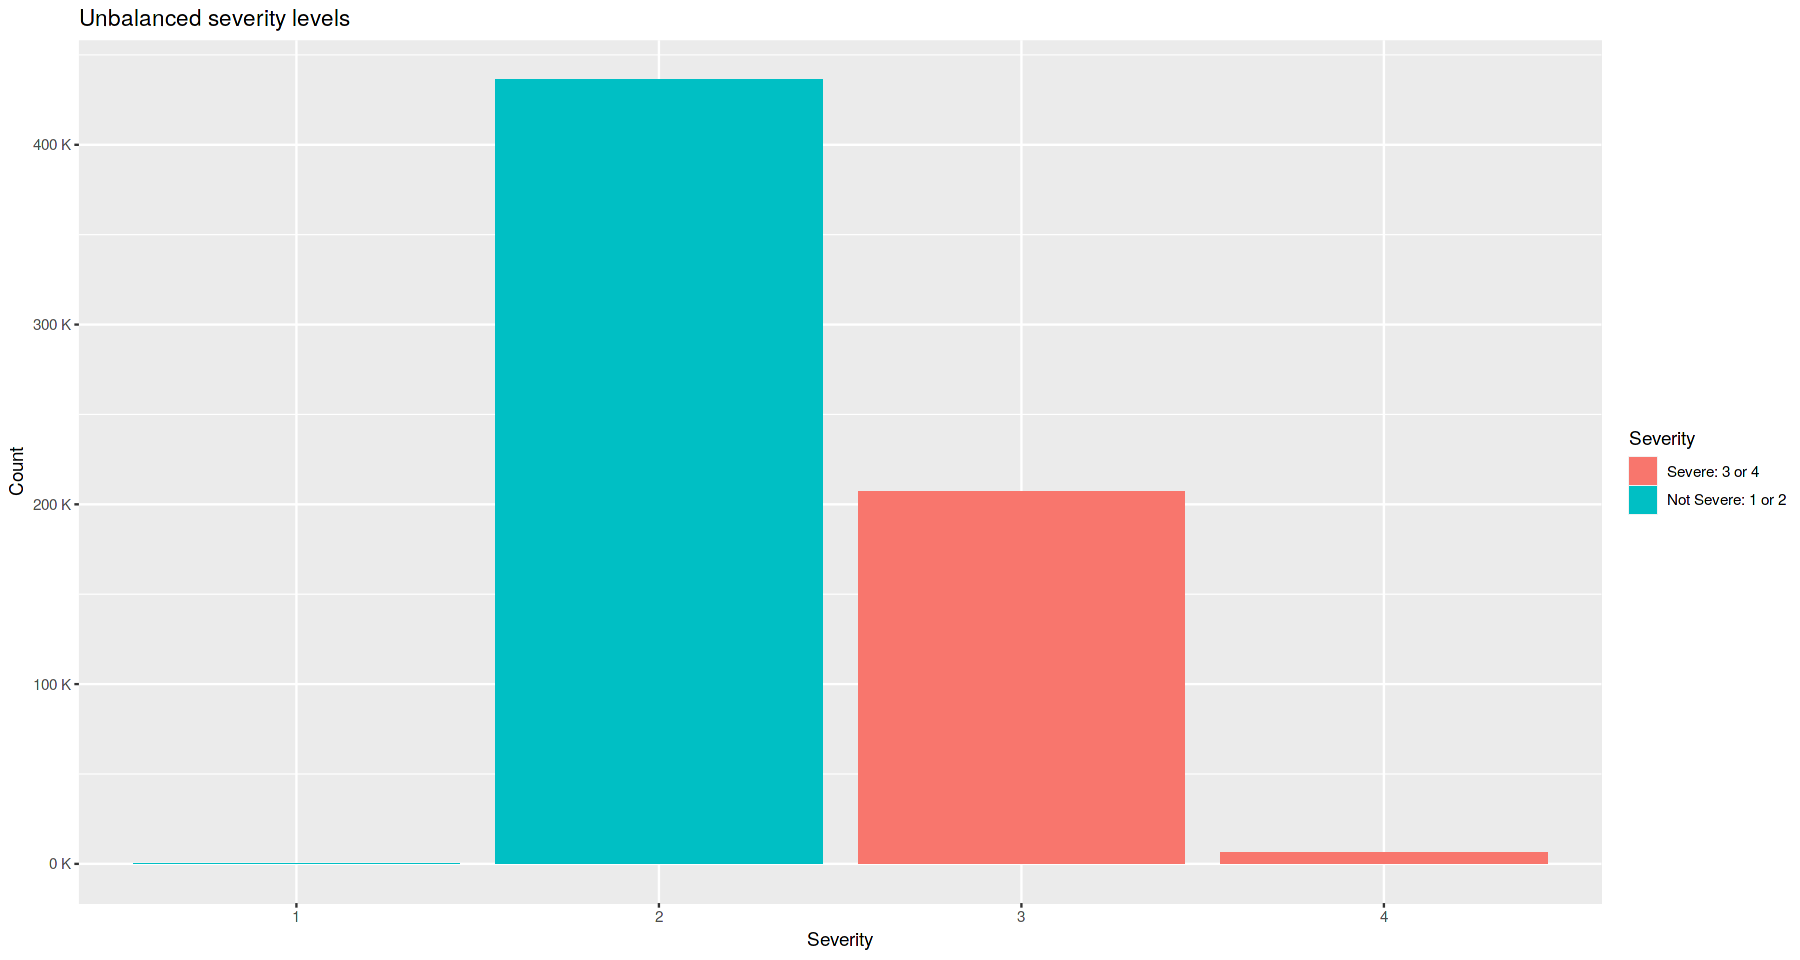

In [34]:
ggplot(df_CA, aes(Severity, fill = !Severity %in% c(3, 4))) +
  geom_bar() +
  scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-03)) +
  scale_fill_discrete(name = "Severity", labels = c("Severe: 3 or 4", "Not Severe: 1 or 2")) +
  labs(y = "Count",
       title = "Unbalanced severity levels")

After grouping:

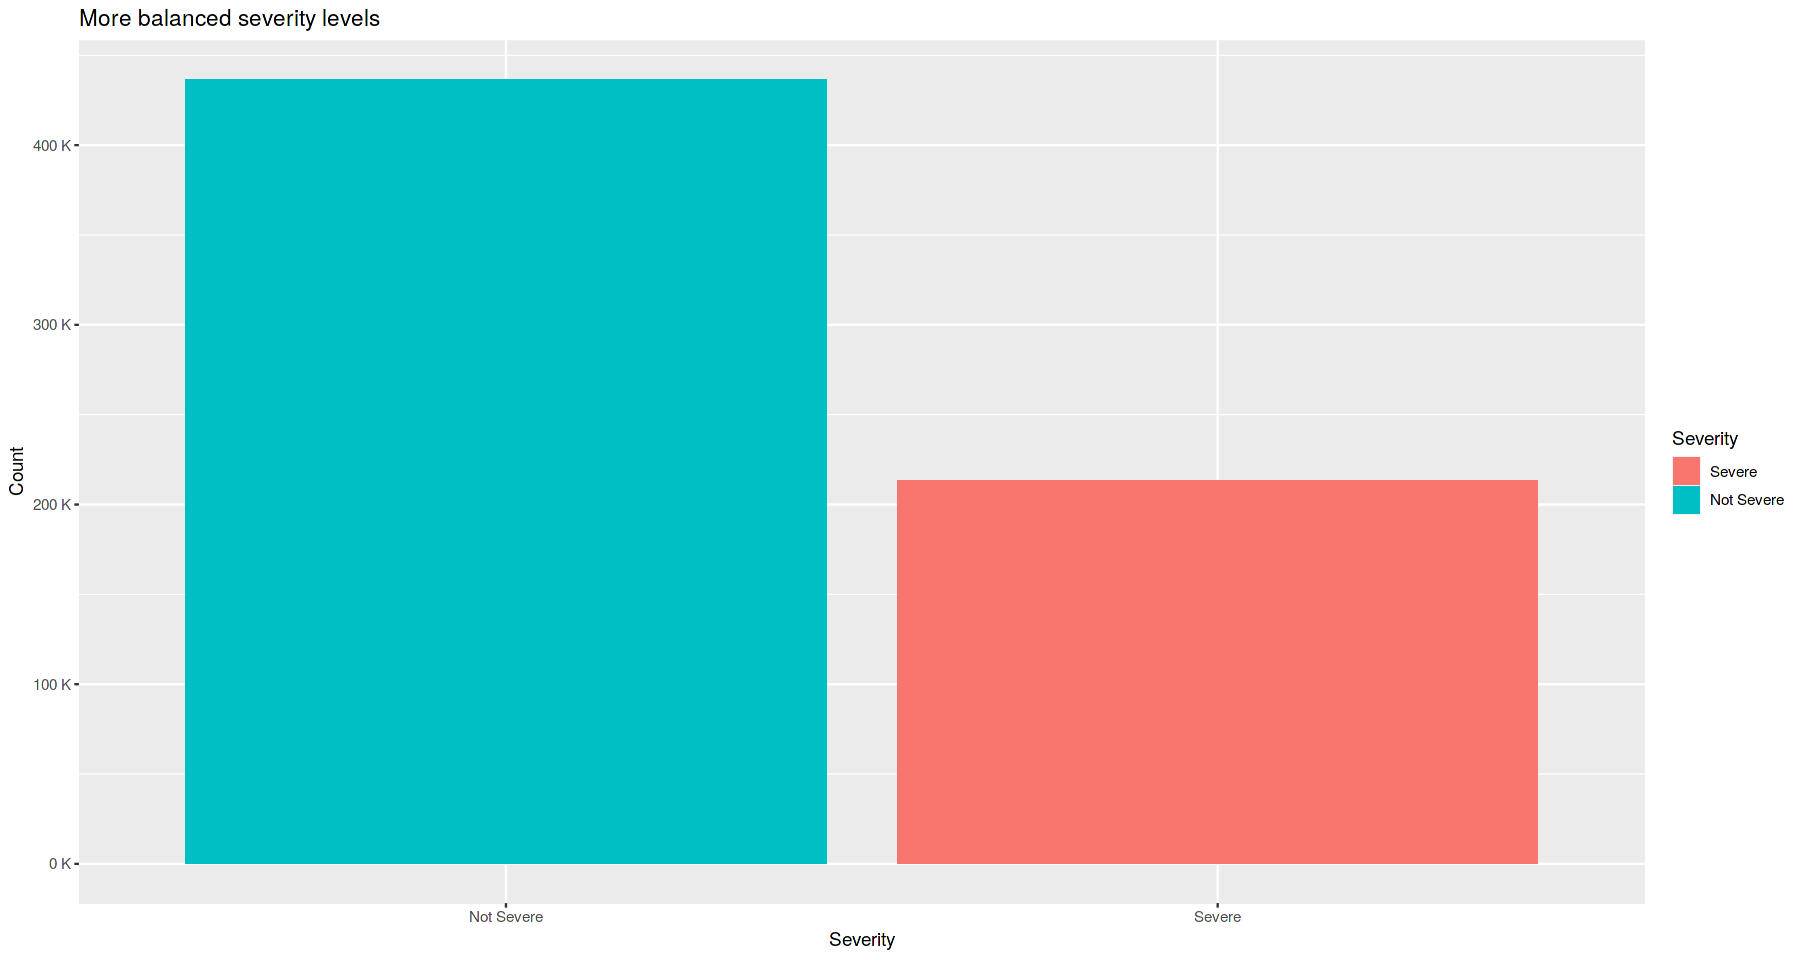

In [35]:
df_label <- df_CA %>%
  mutate("Status" = factor(ifelse(Severity == "3" | Severity == "4", "Severe", "Not Severe"), 
                           levels = c("Not Severe", "Severe")))
ggplot(df_label, aes(Status, fill = !Status == "Severe")) +
  geom_bar() +
  scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-03)) +
  scale_fill_discrete(name = "Severity", labels = c("Severe", "Not Severe")) +
  labs(y = "Count",
       x = "Severity",
       title = "More balanced severity levels")

Later we can use sampling technique to make the data balanced.

## 4. Near Zero-Variance Predictors
Some variables are near zero-variance, which means they cannot provide enough information for us because most of the data have the same values for these variables. What's worse, when we split the dataset, the levels in training dataset and test dataset may not match.

So, we need to remove these variables:

In [36]:
nzv <- nearZeroVar(df_label, saveMetrics = T)
nzv[nzv$nzv,]

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
Visibility,20.89178,0.0087666547,FALSE,TRUE
Amenity,153.99190,0.0003076019,FALSE,TRUE
Bump,6132.87736,0.0003076019,FALSE,TRUE
Crossing,34.74442,0.0003076019,FALSE,TRUE
Give_Way,1434.30022,0.0003076019,FALSE,TRUE
No_Exit,2599.76400,0.0003076019,FALSE,TRUE
Railway,93.66963,0.0003076019,FALSE,TRUE
Roundabout,36120.72222,0.0003076019,FALSE,TRUE
Station,50.95294,0.0003076019,FALSE,TRUE


In [37]:
nzv_cols <- rownames(nzv[nzv$nzv,])
df_label <- df_label %>%
  select(-all_of(nzv_cols))

## 5. Partition
Here, we follow the typical data analysis workflow by splitting the dataset into 3 sub datasets: training(60%), validation(20%) and test(20%).

Use training dataset to build various models, and use validation dataset to compare different models and finally use test dataset to show the final performance.

In [38]:
# reproducibility
set.seed(1)
df_parts <- resample_partition(df_label, c(train = 0.6, valid = 0.2, test = 0.2))
train_set <- as_tibble(df_parts$train)
valid_set <- as_tibble(df_parts$valid)
test_set <- as_tibble(df_parts$test)

# Modeling


## 1. Sampling
Just one more step before we start building models. By grouping the 4 severity levels into 2 levels, now the dataset is more balanced in severity levels. However, from the plot below, we can see the records in each severity level are still not equal. 

This is not a big issue actually, but with a balanced data we can better train the model and interpret the final accuracy more easily (both sensitivity and specificity need to be high to gain a higher total accuracy). So, let's apply some sampling techniques to make the data balanced.

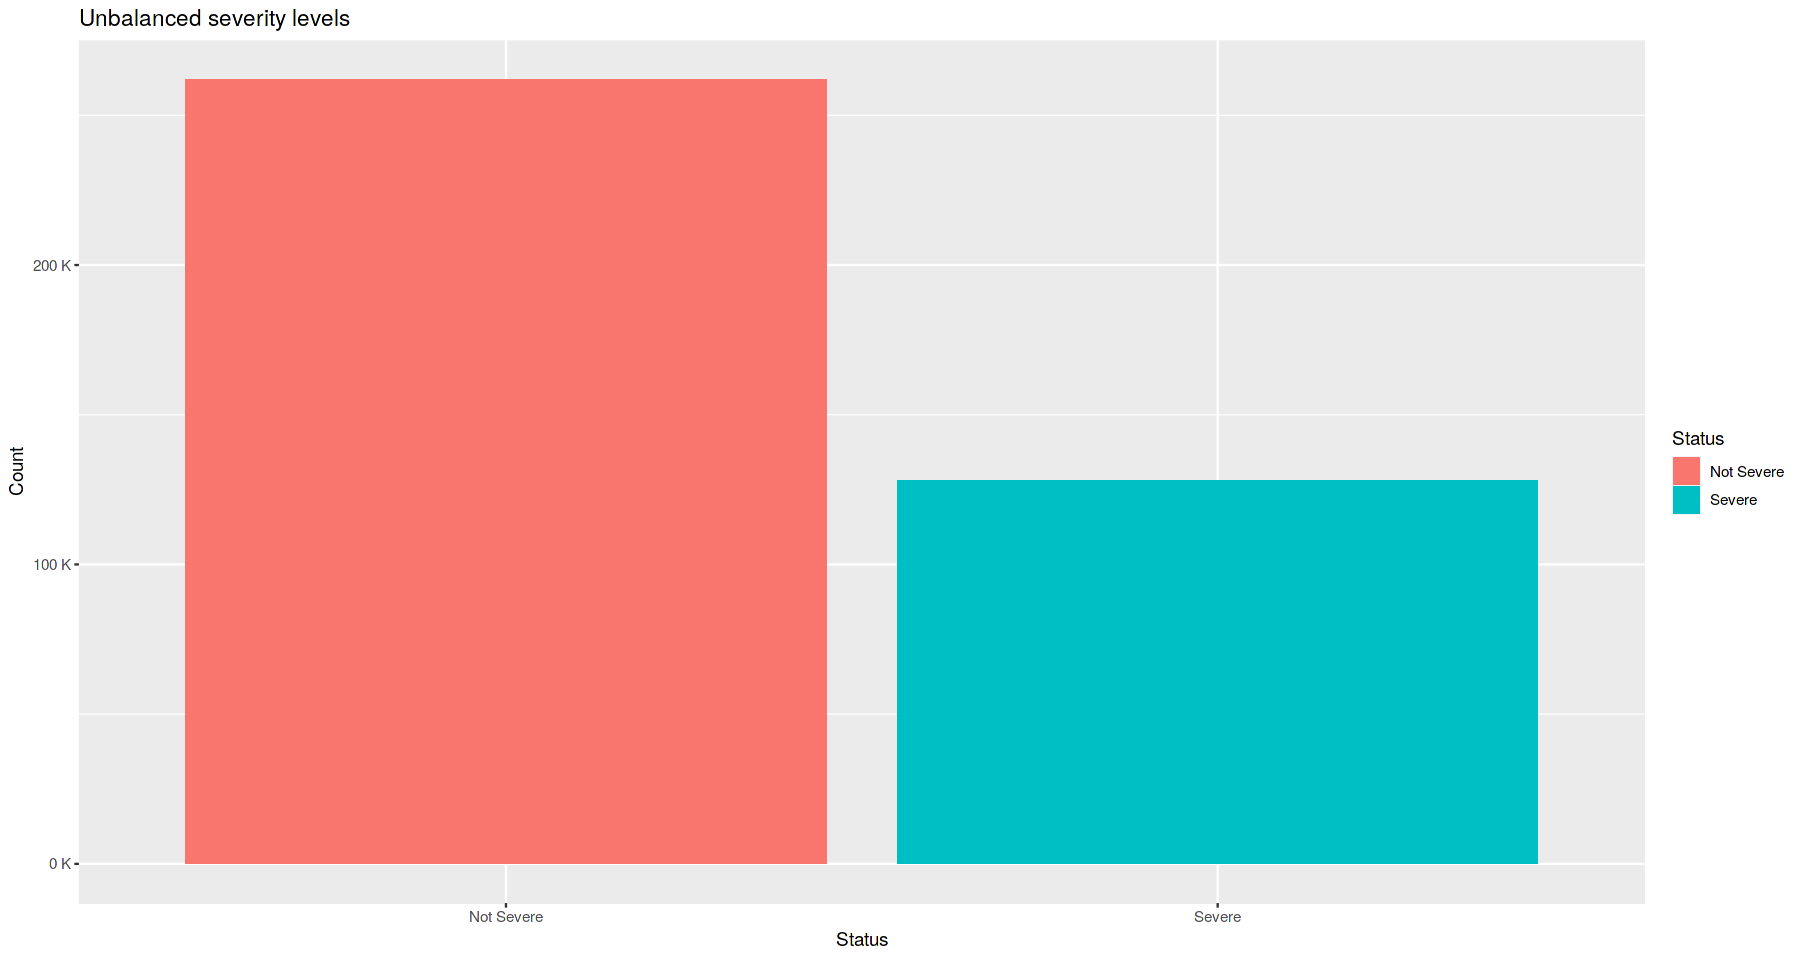

In [39]:
ggplot(train_set, aes(Status)) +
  geom_bar(aes(fill = Status)) +
  scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-03)) +
  labs(y = "Count",
       title = "Unbalanced severity levels")

Here, both oversampling and undersampling are used to make the data balanced. Also, by applying sampling techniques, we reduce the data size to a scale that is more easily to manipulate.

In [40]:
new_train <- ovun.sample(Status ~ ., 
                         data = train_set, 
                         method = "both", p = 0.5, N = 90000, seed = 1)$data %>% as_tibble()

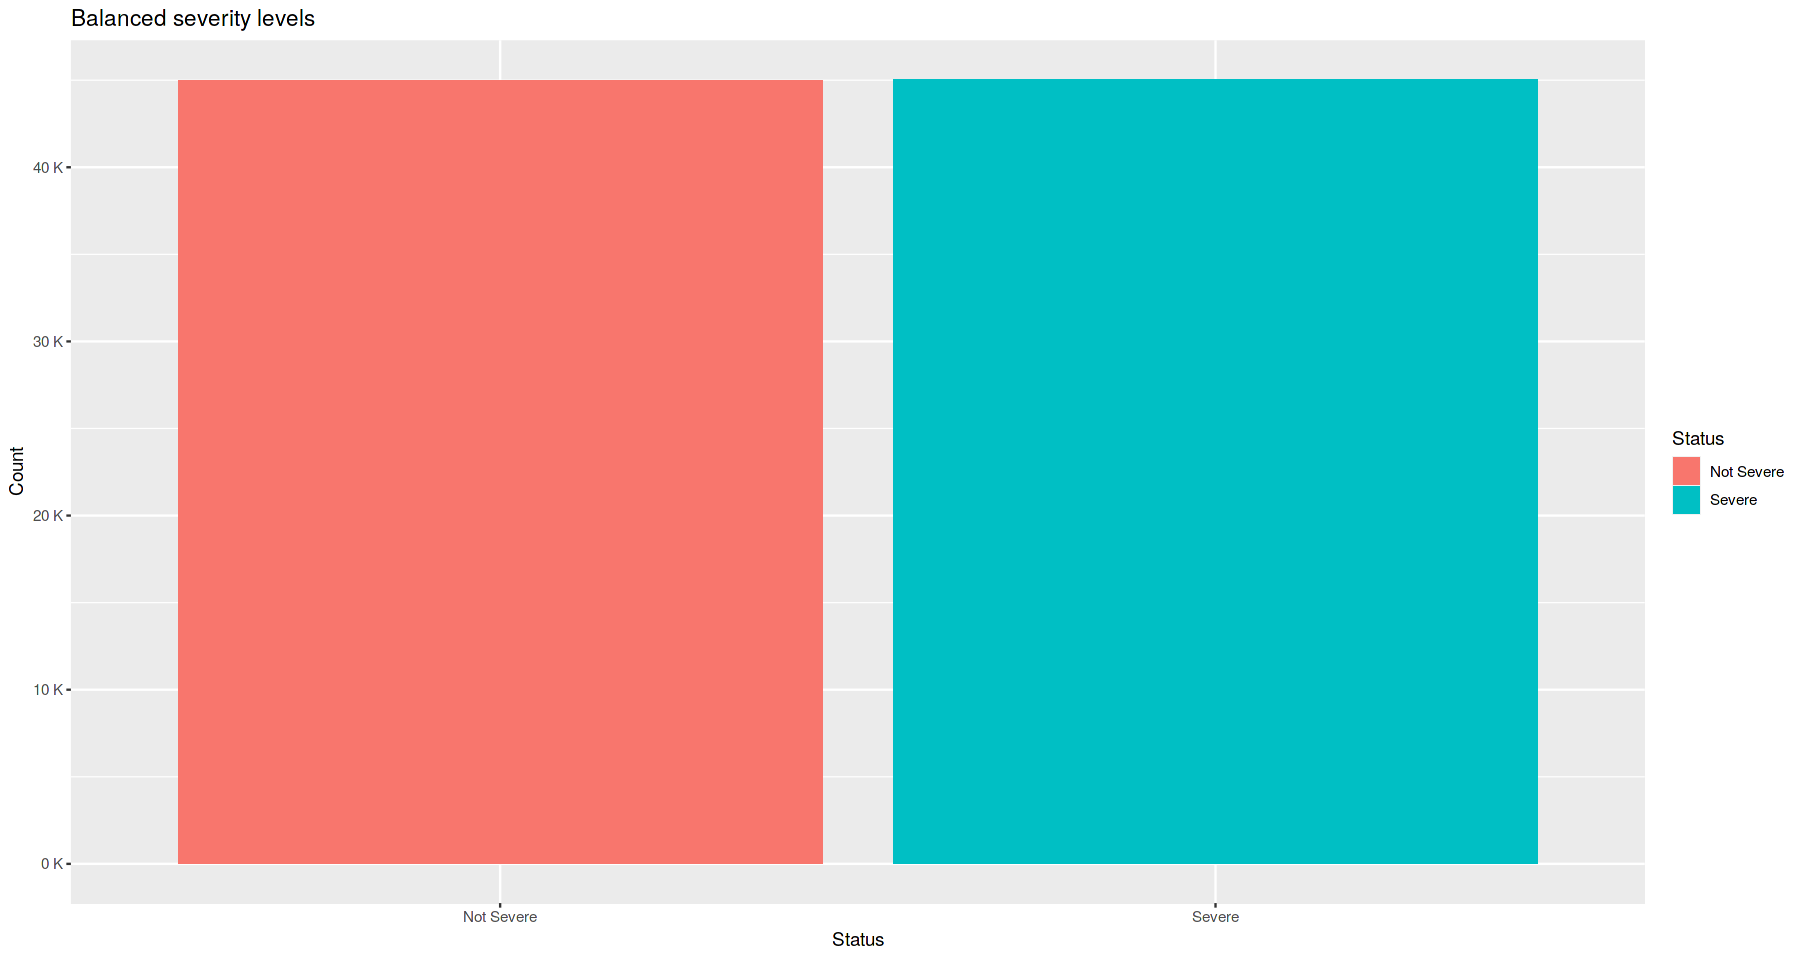

In [41]:
ggplot(new_train, aes(Status)) +
  geom_bar(aes(fill = Status)) +
  scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-03)) +
  labs(y = "Count",
       title = "Balanced severity levels")

new_train <- new_train %>% select(-Severity)

## 2. Logistic regression
Since our response variable has 2 levels now, "Severe" and "Not Severe", it's reasonable that we choose logistic regression as our base line model.

To gain the best formula for logistic regression, we can apply the stepwise model selection process. Here, we cannot use the root-mean-square as our criterion, instead we can use some statistical values, like AIC or BIC. In general, BIC is more strict about variables, the final formula based on BIC will contain less perdictors than using AIC. But there is no absolute conclusion saying which one is the best. So, we just use AIC value here.

Due to the long running time of some functions, intermediate results are stored and read to save time.

The code is shown as annotation.

In [42]:
# model_aic <- glm(Status ~ ., data = new_train, family = "binomial")
# model_aic <- step(model_aic)

In [43]:
model_aic <- readRDS("../input//us-accident-intermediate//lr_model_aic_CA.rds")

These variables are dropped:

In [44]:
model_aic$anova[2:nrow(model_aic$anova), c(1, 6)] %>% as_tibble() %>% mutate(Step = str_sub(Step, start = 3)) %>%
  rename("Vaiables to drop" = Step)

Vaiables to drop,AIC
<chr>,<dbl>
Day,101128.8
Temperature,101126.8
Sunrise_Sunset,101124.8
Nautical_Twilight,101122.9
Astronomical_Twilight,101121.1
Civil_Twilight,101119.9
Humidity,101118.7


The final formula based on AIC value:

In [45]:
model_aic$call

glm(formula = Status ~ TMC + Year + Month + Hour + Wday + Duration + 
    Start_Lat + Start_Lng + Distance + Side + Pressure + Wind_Speed + 
    Weather_Condition + Junction + Traffic_Signal, family = "binomial", 
    data = new_train)

Make predictions on validation dataset. 

Here, we choose 0.6 as the cutoff (transform probability to response variable levels) to gain a higher total accuracy.

We can see the performance of logistic regresson by using confusion matrix:

In [46]:
valid_set <- read_csv("../input//us-accident-intermediate//lr_valid_pred_CA.csv")

Parsed with column specification:
cols(
  Status = col_character(),
  pred = col_double()
)



In [47]:
valid_pred <- valid_set %>%
  mutate(pred = ifelse(pred > 0.6, "Severe", "Not Severe"))

cm <- confusionMatrix(table(valid_pred$pred, valid_pred$Status))
tibble("Accuracy" = cm$overall[[1]], "Sensitivity" = cm$byClass[[1]],
          "Specificity" = cm$byClass[[2]], "Positive term" = cm$positive)
cm

Accuracy,Sensitivity,Specificity,Positive term
<dbl>,<dbl>,<dbl>,<chr>
0.7154623,0.7352326,0.6754223,Not Severe


Confusion Matrix and Statistics

            
             Not Severe Severe
  Not Severe      64002  13951
  Severe          23048  29031
                                         
               Accuracy : 0.7155         
                 95% CI : (0.713, 0.7179)
    No Information Rate : 0.6695         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3898         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.7352         
            Specificity : 0.6754         
         Pos Pred Value : 0.8210         
         Neg Pred Value : 0.5574         
             Prevalence : 0.6695         
         Detection Rate : 0.4922         
   Detection Prevalence : 0.5995         
      Balanced Accuracy : 0.7053         
                                         
       'Positive' Class : Not Severe     
                     

From the result above, we can see the performance of normal logistic regression is not satisfying. Let's try a different model.

## 3. Sparse logistic regression
Since we have so many variables in our dataset, it's possible that some of the variables' coefficients may be near zero in the final best model. So, we decide to try sparse logistic model next.

Sparse logistic regression uses a "Lasso" penalty: as the tuning parameter $\lambda$ increases, it'll force more variables to have coefficient zero. From the plot below, we can see the change of variables' coefficient.

In [48]:
# x <- model.matrix(Status ~ ., data = new_train)
# model_total <- glmnet(x, new_train$Status, family = "binomial")
# plot(model_total)

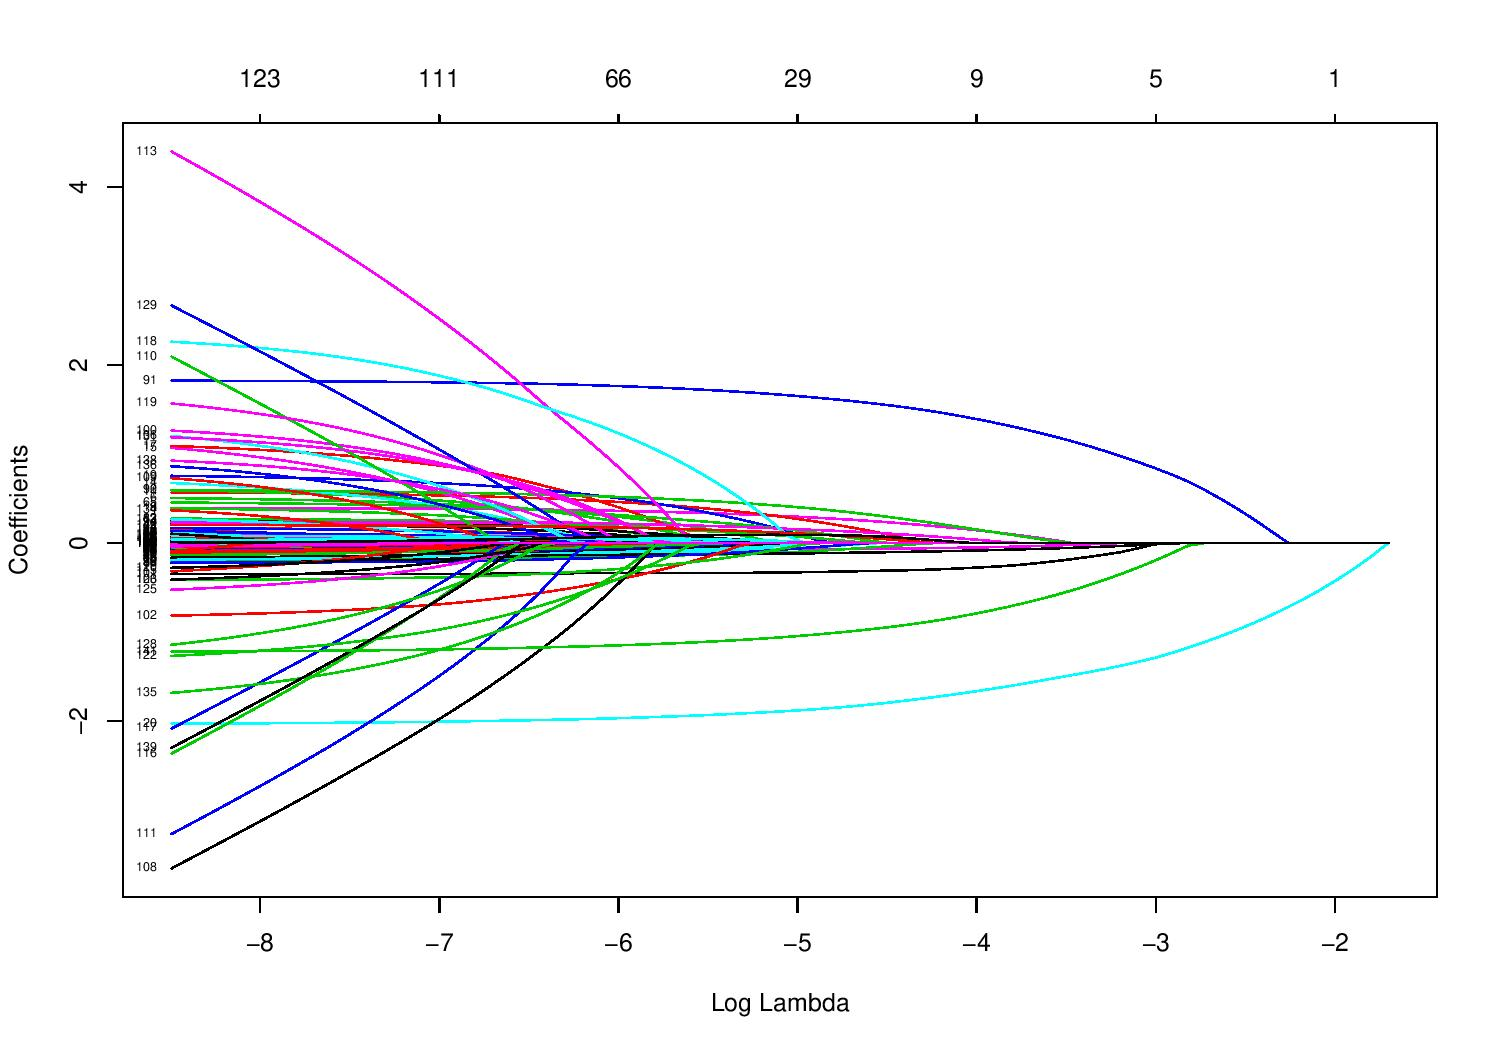

In [49]:
# model_lambda <- cv.glmnet(x, new_train$Status, family = "binomial")
# plot(model_lambda)

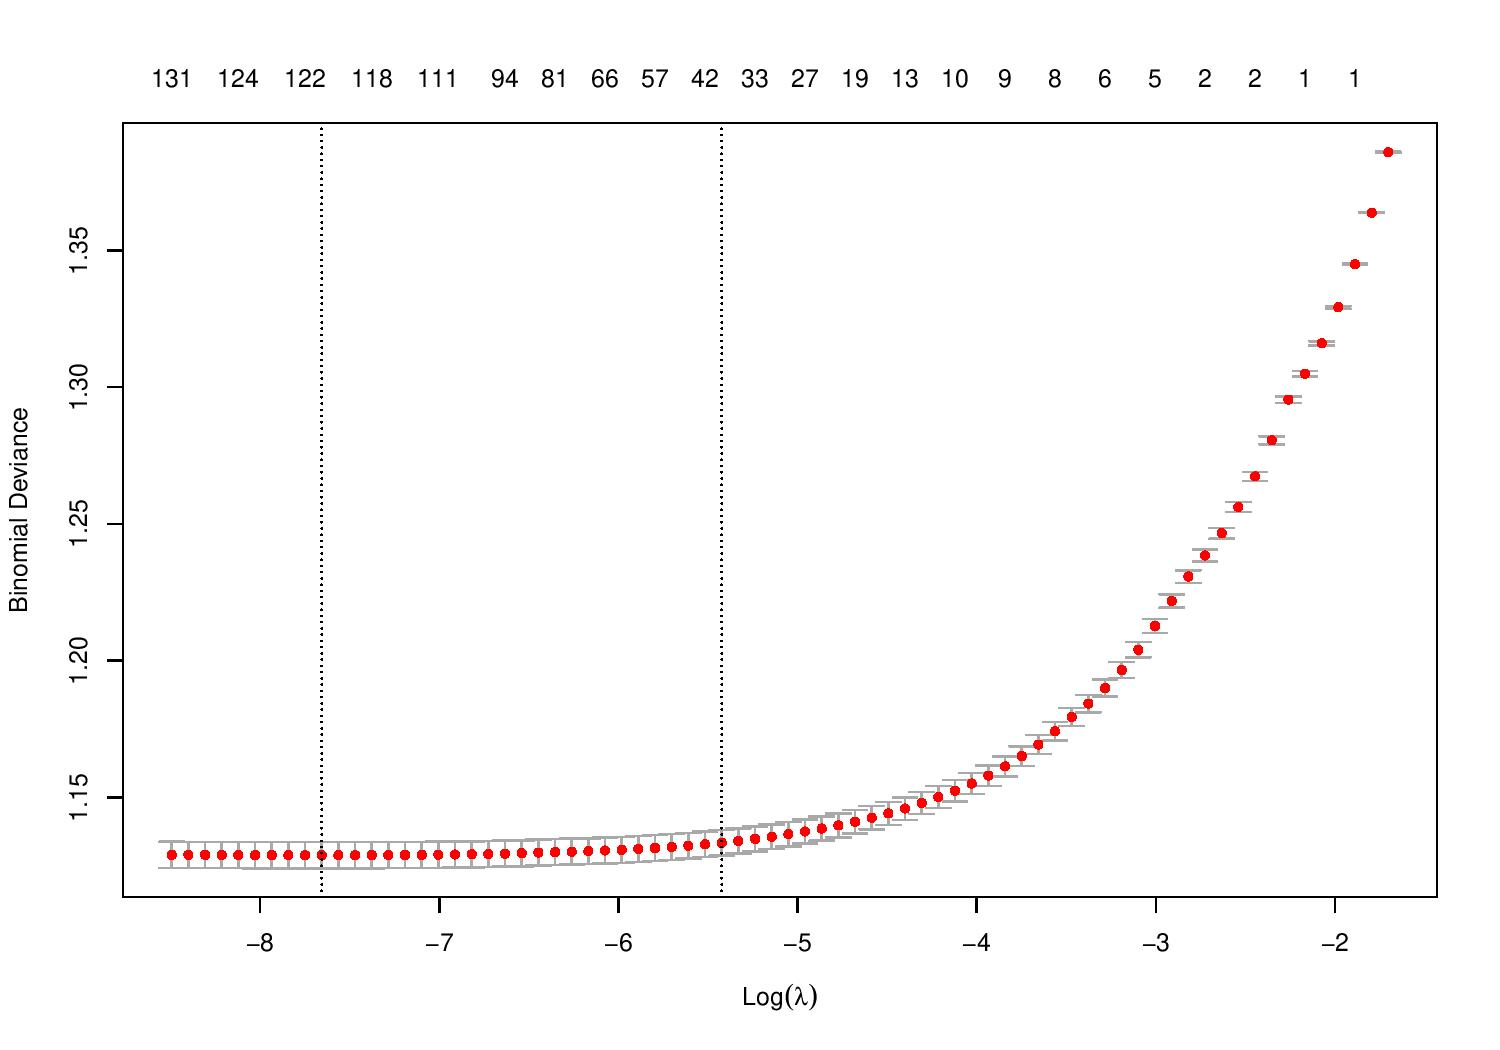

To get the best sparse logistic model, we need to find the best tuning parameter $\lambda$. Cross validation is used to find the best $\lambda$ here.

In [50]:
valid_set <- read_csv("../input//us-accident-intermediate//slr_valid_pred_CA.csv")

Parsed with column specification:
cols(
  Status = col_character(),
  pred = col_double()
)



In [51]:
valid_pred <- valid_set %>%
  mutate(pred = ifelse(pred > 0.6, "Severe", "Not Severe"))

cm <- confusionMatrix(table(valid_pred$pred, valid_pred$Status))
tibble("Accuracy" = cm$overall[[1]], "Sensitivity" = cm$byClass[[1]],
          "Specificity" = cm$byClass[[2]], "Positive term" = cm$positive)
cm

Accuracy,Sensitivity,Specificity,Positive term
<dbl>,<dbl>,<dbl>,<chr>
0.7138375,0.7277552,0.6856505,Not Severe


Confusion Matrix and Statistics

            
             Not Severe Severe
  Not Severe      63354  13512
  Severe          23700  29472
                                          
               Accuracy : 0.7138          
                 95% CI : (0.7114, 0.7163)
    No Information Rate : 0.6695          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.39            
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7278          
            Specificity : 0.6857          
         Pos Pred Value : 0.8242          
         Neg Pred Value : 0.5543          
             Prevalence : 0.6695          
         Detection Rate : 0.4872          
   Detection Prevalence : 0.5911          
      Balanced Accuracy : 0.7067          
                                          
       'Positive' Class : Not Severe      
 

Compared to the previous normal logistic model, it seems the performance is similar. So, sparse logistic regression cannot make better predictions in this case. We still need to explore other models.

## 4. Decision trees
Some algorithms based on trees can do a good job in classification. Also, these algorithms have a built in feature selection process, which means we don't need to be very picky about our variables.

Next, we are going to try decison trees, a very useful algorithm with a readily comprehensible concept. 

In [52]:
model_decision <- rpart(Status ~ ., data = new_train, method = "class", minsplit = 20, cp = 0.001)

Usually we can plot the decision tree to see all the nodes. But here to reach a higher accuracy, we have to take many variables into account (set cp = 0.001), which makes the final tree quite complicated and cannot be easily plotted. 

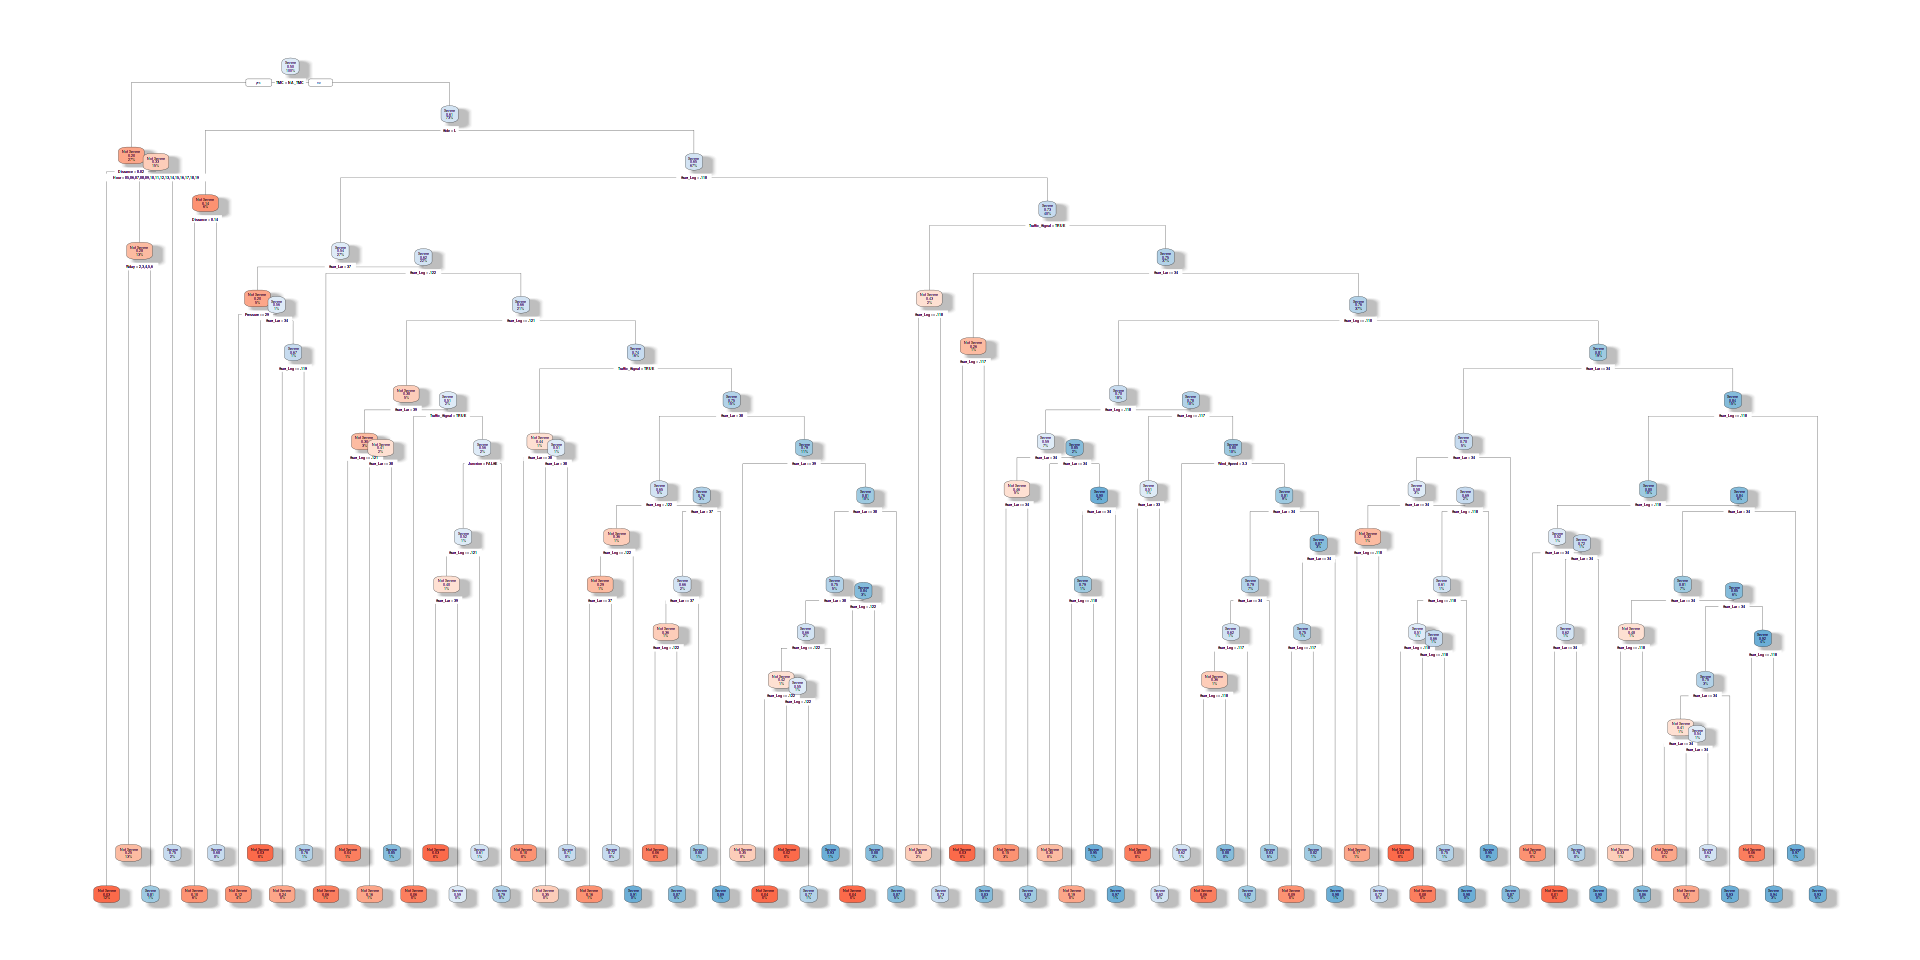

In [53]:
fig(16, 8)
rpart.plot(model_decision, box.palette = "RdBu", shadow.col = "grey", )

After we build the tree, let's make predictions on the validation dataset.

In [54]:
valid_set <- as_tibble(df_parts$valid)
valid_pred <- valid_set %>%
  mutate(pred = predict(model_decision, valid_set, type = "class"))

cm <- confusionMatrix(table(valid_pred$pred, valid_pred$Status))
tibble("Accuracy" = cm$overall[[1]], "Sensitivity" = cm$byClass[[1]],
          "Specificity" = cm$byClass[[2]], "Positive term" = cm$positive)
cm

Accuracy,Sensitivity,Specificity,Positive term
<dbl>,<dbl>,<dbl>,<chr>
0.8525123,0.8523101,0.852922,Not Severe


Confusion Matrix and Statistics

            
             Not Severe Severe
  Not Severe      74197   6322
  Severe          12857  36662
                                          
               Accuracy : 0.8525          
                 95% CI : (0.8506, 0.8544)
    No Information Rate : 0.6695          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6791          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8523          
            Specificity : 0.8529          
         Pos Pred Value : 0.9215          
         Neg Pred Value : 0.7404          
             Prevalence : 0.6695          
         Detection Rate : 0.5706          
   Detection Prevalence : 0.6192          
      Balanced Accuracy : 0.8526          
                                          
       'Positive' Class : Not Severe      
 

From the result above, we can see decision tree really gives a better performance than the previous two logistic regression model. What's more, it takes much less time to train a decision tree than logistic models.

So far, decision tree is the best model we have.

## 5. Random forest

As we all know, decision tree has an obvious disadvantage (not quite obvious here though) that it may have a high accuracy on training dataset but a much lower accuracy on test dataset, which is the result of overfitting. 

And random forest can alleviate this overfitting effect by applying a special sampling technique called "bootstrapping". By analyzing the final out-of-bag error rate, a more practical model can be obtained. 

Let's see if random forest can imporve the accuracy even better.

In [55]:
# model_rf <- randomForest(Status ~ ., data = new_train, mtry = 6, ntree = 500)

These two arguments here are very important:

| Name   | Description |
|--------|------------------------------------------------------------------|
| mtry   | Number of variables randomly sampled as candidates at each split |
| ntree  | Number of trees to grow |

To train a better random forest model, we need to find proper values for these two arguments.

Use the plot below to see whether ```ntree = 500``` is enough: 

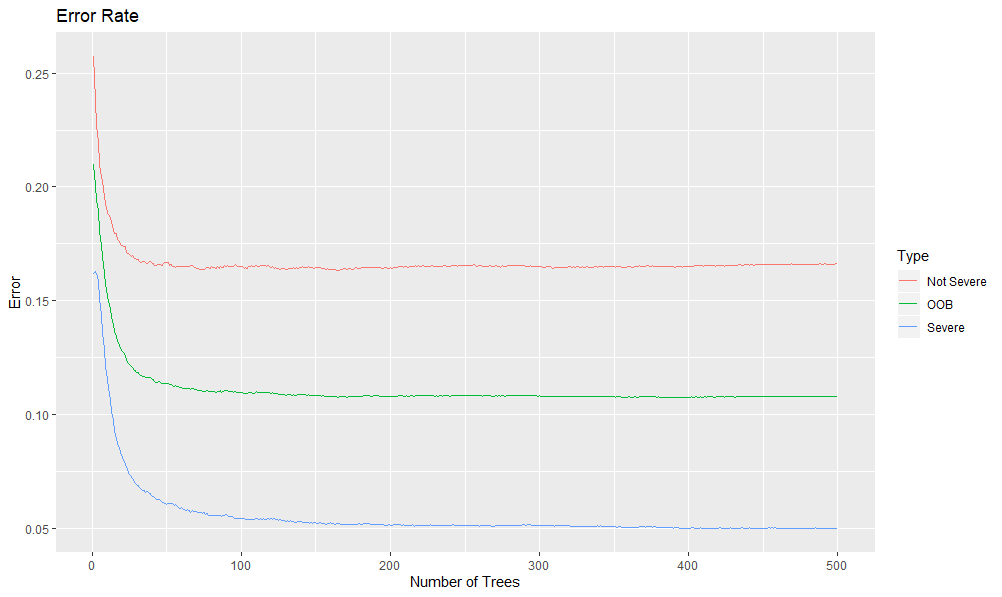

As we can see, as the number of trees increases, the error rate tends to be a fixed number. So, ```ntree = 500``` is enough.

Let's find out the best value for ```mtry```:

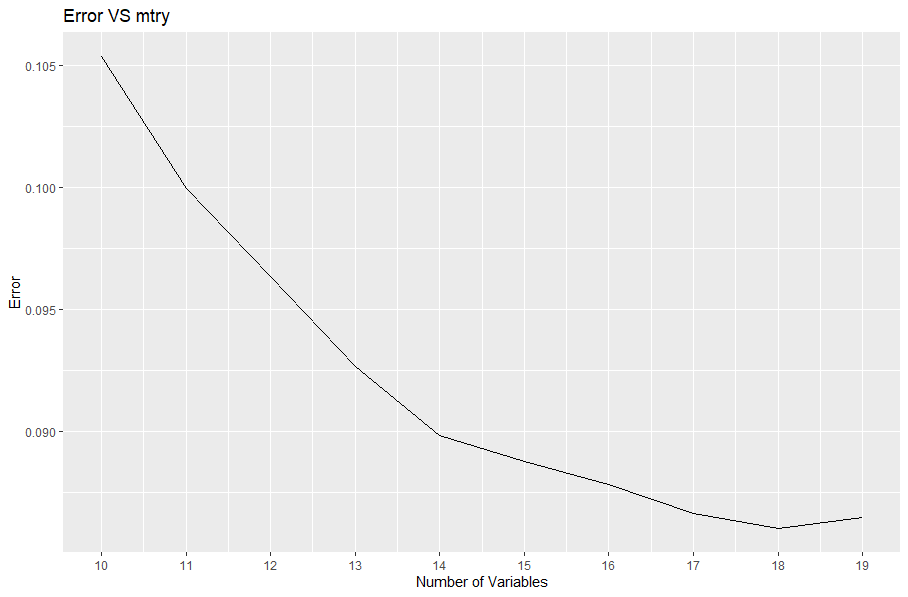

It's obvious that ```mtry = 18``` should be the best input.

Next, we use ```ntree = 500``` and ```mtry = 18``` to build the random forest model and make predictions on validation dataset.

In [56]:
valid_pred <- read_csv("../input//us-accident-intermediate/rf_valid_pred_CA.csv")

Parsed with column specification:
cols(
  Status = col_character(),
  pred = col_character()
)



In [57]:
cm <- confusionMatrix(table(valid_pred$pred, valid_pred$Status))
tibble("Accuracy" = cm$overall[[1]], "Sensitivity" = cm$byClass[[1]],
          "Specificity" = cm$byClass[[2]], "Positive term" = cm$positive)
cm

Accuracy,Sensitivity,Specificity,Positive term
<dbl>,<dbl>,<dbl>,<chr>
0.8849106,0.870184,0.9147357,Not Severe


Confusion Matrix and Statistics

            
             Not Severe Severe
  Not Severe      75753   3665
  Severe          11301  39319
                                          
               Accuracy : 0.8849          
                 95% CI : (0.8832, 0.8866)
    No Information Rate : 0.6695          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7511          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8702          
            Specificity : 0.9147          
         Pos Pred Value : 0.9539          
         Neg Pred Value : 0.7767          
             Prevalence : 0.6695          
         Detection Rate : 0.5825          
   Detection Prevalence : 0.6107          
      Balanced Accuracy : 0.8925          
                                          
       'Positive' Class : Not Severe      
 

According to the result above, random forest does improve the accuracy compared to decision tree. However, the time consumed by training and finding the best random forest model is tremendously longer than training a decent decision tree model.

# Conclusion

In conlusion, considering both performance and the time needed to train the model, I prefer using decision tree to make predictions. But if we care about nothing but accuracy, then I suppose random forest will be the winner.

The table below contains the performance of each model:

| Model | Accuracy | Sensitivity | Specificity | Positive term |
|-------|----------|-------------|-------------|---------------|
| Logistic Regression | 0.7154623 | 0.7352326 | 0.6754223 | Not Severe |
| Sparse Logistic Regression | 0.7138375 | 0.7277552 | 0.6856505 | Not Severe |
| Decision Tree | 0.8525123 | 0.8523101 | 0.852922 | Not Severe |
| Random Forest | 0.8849106 | 0.870184 | 0.9147357 | Not Severe |

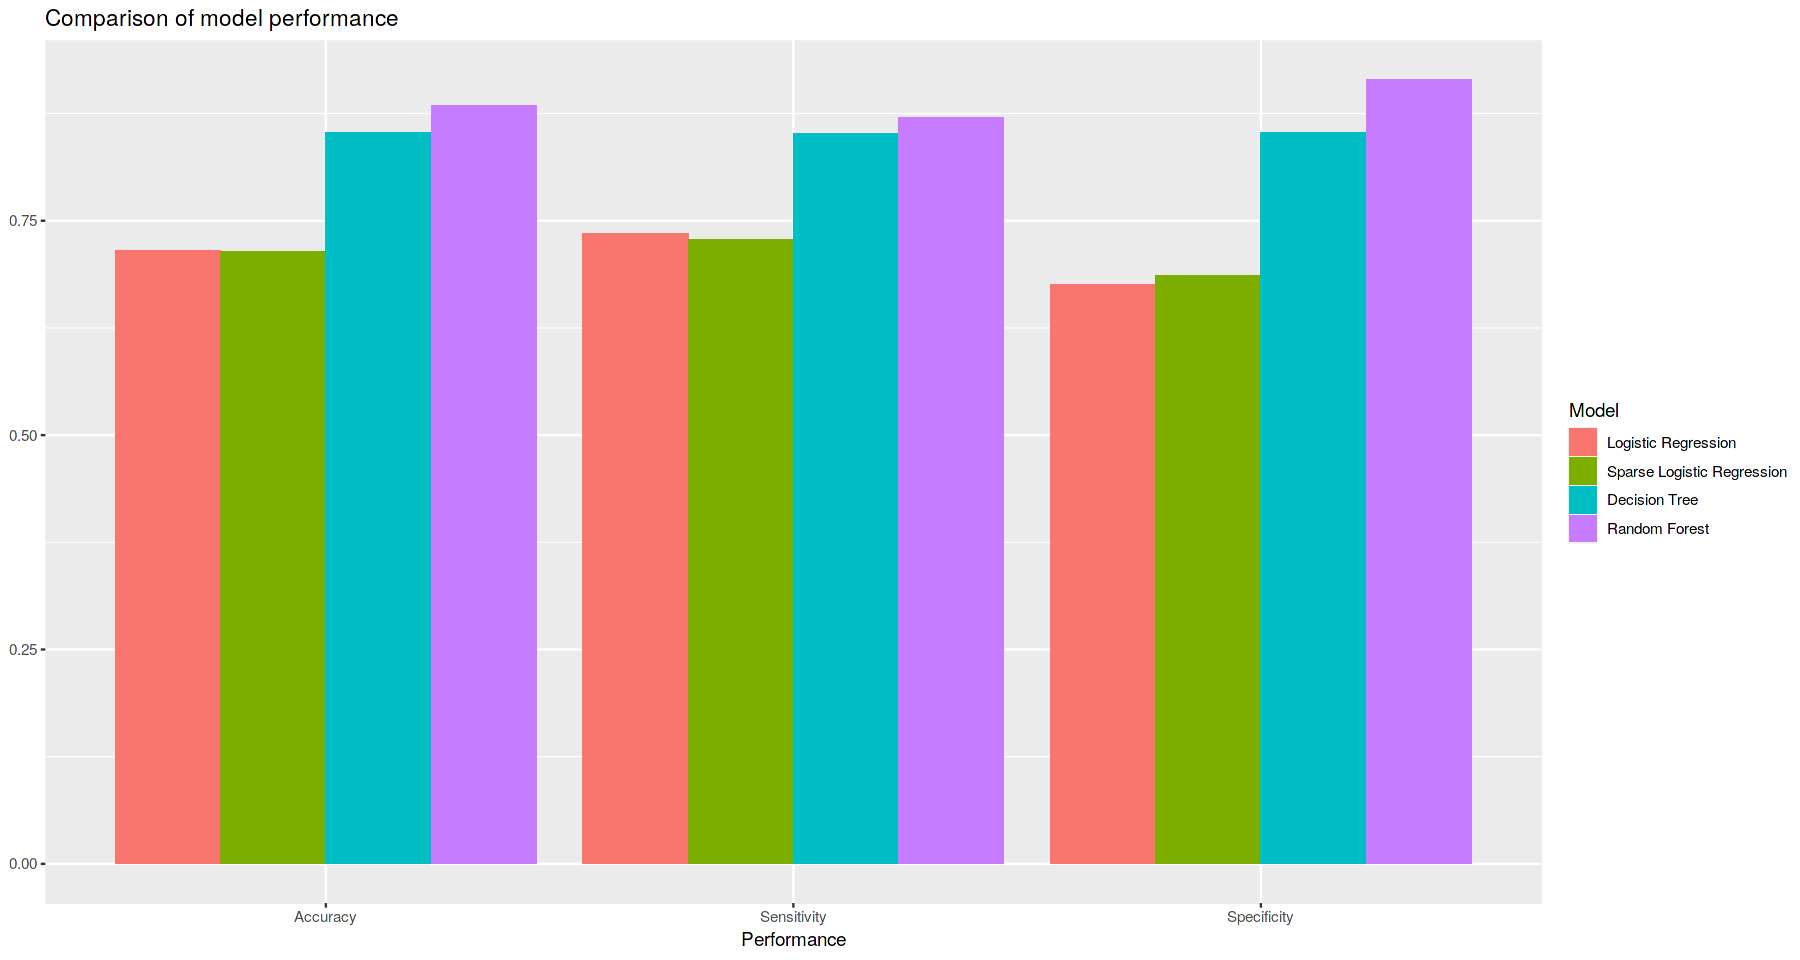

In [58]:
result  <- tibble("Model" = c("Logistic Regression", "Sparse Logistic Regression", "Decision Tree", "Random Forest"),
                 "Accuracy" = c(0.7154623, 0.7138375, 0.8525123, 0.8849106),
                 "Sensitivity" = c(0.7352326, 0.7277552, 0.8523101, 0.870184),
                 "Specificity" = c(0.6754223, 0.6856505, 0.852922, 0.9147357)) %>%
pivot_longer(2:4, names_to = "type", values_to = "value")

fig(15, 8)
result %>% ggplot(aes(type, value, fill = factor(Model, levels = c("Logistic Regression", "Sparse Logistic Regression", "Decision Tree", "Random Forest")))) +
geom_col(position = "dodge") +
scale_fill_discrete(name = "Model") +
labs(x = "Performance",
    y = NULL,
    title = "Comparison of model performance")